In [1]:
import pandas as pd
from pandas import Series, DataFrame
import json 
import os
import requests 
import math
import sqlite3
import copy
import re
import seaborn as sns
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
matplotlib.rcParams.update({'font.size': 15})

In [2]:
#code references for the new data
coderef = pd.read_csv("newbudget1codereferences.csv")
#services provided per planning
planningservice = coderef[coderef["Agency"]== "65 -  PLANNING"].copy()
planningservice.head()

Organization          Agency  \
513  65101 - PL NEIGH PLAN PRES DESIGN ADMI  65 -  PLANNING   
514        65110 - PL NEIGHBORHOOD PLANNING  65 -  PLANNING   
515        65111 - PL PRESERVATION PLANNING  65 -  PLANNING   
516         65112 - PL MADISON ARTS PROGRAM  65 -  PLANNING   
517      65113 - PL URBAN DESIGN COMMISSION  65 -  PLANNING   

                                   Service                       Subservice  \
513  651 -  NEIGH PLANNING PRES AND DESIGN           6501 -  ADMINISTRATION   
514  651 -  NEIGH PLANNING PRES AND DESIGN    6510 -  NEIGHBORHOOD PLANNING   
515  651 -  NEIGH PLANNING PRES AND DESIGN    6511 -  PRESERVATION PLANNING   
516  651 -  NEIGH PLANNING PRES AND DESIGN     6512 -  MADISON ARTS PROGRAM   
517  651 -  NEIGH PLANNING PRES AND DESIGN  6513 -  URBAN DESIGN COMMISSION   

              Location  
513  0000 -  UNDEFINED  
514  0000 -  UNDEFINED  
515  0000 -  UNDEFINED  
516  0000 -  UNDEFINED  
517  0000 -  UNDEFINED

In [3]:
#origional data 
madisonfinancedf = pd.read_csv("budget.csv")
madisonfinancedf.head()

Agency                       Organization Account Type  \
0  50 -  LIBRARY         50100 - LIB PUBLIC SERVICE      Revenue   
1  50 -  LIBRARY       50300 - LIB COL RES & ACCESS      Revenue   
2  50 -  LIBRARY             50400 - LIB FACILITIES      Revenue   
3    51 -  PARKS  51220 - PARK MTC FORESTRY GENERAL      Revenue   
4  44 -  STREETS    44220 - ST RECYCLING COLLECTION      Revenue   

              Character Code                                  Object  \
0      41 - GENERAL REVENUES               41110 - REAL ESTATE TAXES   
1      41 - GENERAL REVENUES               41110 - REAL ESTATE TAXES   
2      41 - GENERAL REVENUES               41110 - REAL ESTATE TAXES   
3           49 - TRANSFER IN  49124 - TRANSFER IN FROM OTHER RESTRIC   
4  43 - CHARGES FOR SERVICES             43445 - SALE OF RECYCLABLES   

          2015         2016         2017         2018  
0 -11355535.00 -11941627.00 -12603779.00 -13080447.90  
1  -2056164.00  -2222626.00  -2199357.00  -2268968.77  
2  -1766869.00  -1768986.00  -1963404.00  -1976738.18  
3  -1000000.00  -2500000.00  -3100342.25         0.00  
4   -841012.69   -866760.77  -1218608.41   -892803.25

In [4]:
#copy of origional data
mfdf = madisonfinancedf.copy()
mfdf = pd.DataFrame(mfdf)
mfdf = mfdf.sort_values('Agency')
mfdf.head()


Agency                   Organization Account Type  \
8326  00 -  UNDEFINED  110020 - GENERAL FUND EXPENSE      Expense   
1761  00 -  UNDEFINED  110020 - GENERAL FUND EXPENSE      Expense   
8332  00 -  UNDEFINED  110020 - GENERAL FUND EXPENSE      Expense   
6928  00 -  UNDEFINED  110020 - GENERAL FUND EXPENSE      Expense   
8331  00 -  UNDEFINED  110020 - GENERAL FUND EXPENSE      Expense   

                 Character Code                                Object  \
8326  58 - INTER DEPART BILLING  58180 - ID BILLING TO MONONA TERRACE   
1761              52 - BENEFITS                         52715 - GRANT   
8332  58 - INTER DEPART BILLING           58186 - ID BILLING TO WATER   
6928    54 - PURCHASED SERVICES           54645 - CONSULTING SERVICES   
8331  58 - INTER DEPART BILLING         58185 - ID BILLING TO TRANSIT   

          2015      2016      2017     2018  
8326       NaN       NaN       NaN      0.0  
1761      0.00    780.68      0.00      0.0  
8332       NaN       NaN       NaN      0.0  
6928  68531.03  75298.12  72167.32  83768.3  
8331       NaN       NaN       NaN      0.0

In [5]:
#Cleaning up the data
mfdf["Agency"] = mfdf["Agency"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf["Organization"]= mfdf["Organization"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf["Character Code"]= mfdf["Character Code"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf["Object"]=mfdf["Object"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf.head()

Agency          Organization Account Type        Character Code  \
8326  UNDEFINED  GENERAL FUND EXPENSE      Expense  INTER DEPART BILLING   
1761  UNDEFINED  GENERAL FUND EXPENSE      Expense              BENEFITS   
8332  UNDEFINED  GENERAL FUND EXPENSE      Expense  INTER DEPART BILLING   
6928  UNDEFINED  GENERAL FUND EXPENSE      Expense    PURCHASED SERVICES   
8331  UNDEFINED  GENERAL FUND EXPENSE      Expense  INTER DEPART BILLING   

                            Object      2015      2016      2017     2018  
8326  ID BILLING TO MONONA TERRACE       NaN       NaN       NaN      0.0  
1761                         GRANT      0.00    780.68      0.00      0.0  
8332           ID BILLING TO WATER       NaN       NaN       NaN      0.0  
6928           CONSULTING SERVICES  68531.03  75298.12  72167.32  83768.3  
8331         ID BILLING TO TRANSIT       NaN       NaN       NaN      0.0

In [6]:
#data frame for planning yearly budget by charactercodes 
agency = mfdf[mfdf['Agency']=="PLANNING"]
agency1 = mfdf[mfdf['Agency']=="COMMUNITY DEVELOPMENT"]
agencydic= {"2015": {}, "2016": {} , "2017": {} , "2018": {} }
for year in agencydic:
    for code in agency["Organization"]:
        if code not in agencydic[year]:
            a = agency[agency["Organization"]==code]
            summ = a[year].sum()
            agencydic[year][code] = copy.deepcopy(summ)
adf = pd.DataFrame(agencydic["2015"], index=["2015"])
bdf = pd.DataFrame(agencydic["2016"], index=["2016"])
cdf = pd.DataFrame(agencydic["2017"], index=["2017"])
ddf = pd.DataFrame(agencydic["2018"], index=["2018"])
planyearorg = pd.concat([adf, bdf, cdf, ddf])
planyearorg=planyearorg/1000000

planyearorg


PL METROPOLITAN PLANNING ORG  PL NEIGH PLAN PRES DESIGN ADMI  \
2015                      0.283503                        0.297465   
2016                      0.258890                        0.335264   
2017                      0.140959                        0.377865   
2018                      0.094496                        0.421926   

      PL COMP NEIGH SPEC AREA PLAN  PL NEIGHBORHOOD PLANNING  \
2015                      0.219246                  0.252465   
2016                      0.365725                  0.281964   
2017                      0.480060                  0.360768   
2018                      0.420081                  0.377337   

      PL TRANSPORTATION PLAN NON MPO  PL COMP PLAN AND DEVELOP ADMIN  \
2015                        0.134689                        0.340130   
2016                        0.203631                        0.418839   
2017                        0.221787                        0.603246   
2018                        0.365577                        0.568047   

      PL PRESERVATION PLANNING  PL SPECIAL PROJECTS  \
2015                  0.109043             0.212096   
2016                  0.108182             0.301593   
2017                  0.117936             0.100695   
2018                  0.078490             0.127823   

      PL RESEARCH INFORMATION SERVIC  PL PLAN COMMISSION DEV REVIEW  \
2015                        0.225441                       0.296121   
2016                        0.191919                       0.236606   
2017                        0.162118                       0.196876   
2018                        0.109070                       0.298799   

      PL GEO GIS ADMINISTRATION MAIN  PL URBAN DESIGN COMMISSION  \
2015                        0.106075                    0.111734   
2016                        0.048955                    0.110497   
2017                        0.087631                    0.005203   
2018                        0.102560                    0.000000   

      PL MADISON ARTS PROGRAM  PL TIF CDA REDEVELOPMENT PLAN  \
2015                 1.942465                       0.000000   
2016                 0.182965                       0.000000   
2017                 0.218855                       0.000025   
2018                 0.202924                       0.000000   

      PL DEVELP LAND USE ZONING REG  PL LAND USE POLICY INTERGOV PL  
2015                            0.0                             0.0  
2016                            0.0                             0.0  
2017                            0.0                             0.0  
2018                            0.0                             0.0

In [7]:
a=planyearorg.transpose()
a.reset_index(level=0, inplace=True)
a["index"]

0       PL METROPOLITAN PLANNING ORG
1     PL NEIGH PLAN PRES DESIGN ADMI
2       PL COMP NEIGH SPEC AREA PLAN
3           PL NEIGHBORHOOD PLANNING
4     PL TRANSPORTATION PLAN NON MPO
5     PL COMP PLAN AND DEVELOP ADMIN
6           PL PRESERVATION PLANNING
7                PL SPECIAL PROJECTS
8     PL RESEARCH INFORMATION SERVIC
9      PL PLAN COMMISSION DEV REVIEW
10    PL GEO GIS ADMINISTRATION MAIN
11        PL URBAN DESIGN COMMISSION
12           PL MADISON ARTS PROGRAM
13     PL TIF CDA REDEVELOPMENT PLAN
14     PL DEVELP LAND USE ZONING REG
15    PL LAND USE POLICY INTERGOV PL
Name: index, dtype: object

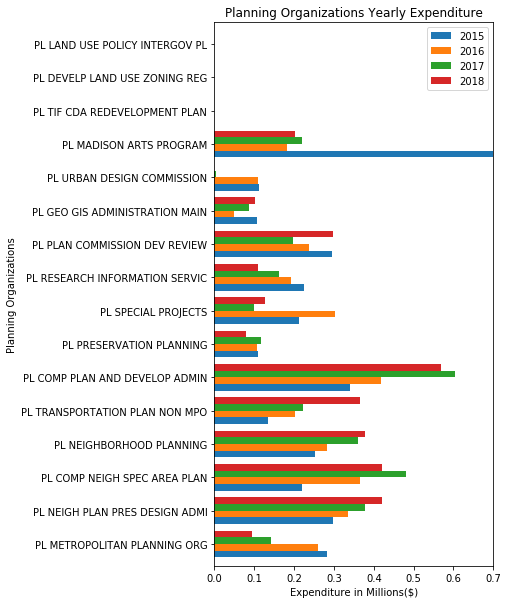

In [8]:
#planning organizations by yearly expenditure horizontal bar 
data=planyearorg.T.plot.barh(figsize=(5,10),title="Planning Organizations Yearly Expenditure", width=0.8) 
data.set_ylabel("Planning Organizations")
data.set_xlabel("Expenditure in Millions($)")
data.set_xlim(0,0.7)
data.legend(loc='upper right')

In [9]:
#http://data-cityofmadison.opendata.arcgis.com/datasets/43743f819e1d4e7ab35a202e442cf27c_28/data
#Data from city of madison on Bus Rapid Routes 
#Planning Transportation MPO
#https://www.cityofmadison.com/dpced/planning/documents/MIM%20priority%20recomendations.pdf
import pandas
from pandas.io.json import json_normalize

res = requests.get("https://opendata.arcgis.com/datasets/43743f819e1d4e7ab35a202e442cf27c_28.geojson")
j = res.json()

dic= []
for object in j["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("busrapidtransitstops.csv", encoding='utf-8', index=False)            
rbusdata=pd.read_csv("busrapidtransitstops.csv")
rbusdata=rbusdata.set_index(rbusdata["OBJECTID"])
rbusdata["Notes"] = rbusdata['Notes'].fillna("")
rbusdata["MetroID"] = rbusdata['MetroID'].fillna(0)
rbusdata.head()

MetroID                      Notes  OBJECTID Type  \
OBJECTID                                                      
1           581.0  Relo back from ns Charter         1  NaN   
2             0.0                                    2  NaN   
3           883.0                                    3  NaN   
4          1101.0                                    4  NaN   
5          1323.0                                    5  NaN   

                                      coordinates  stop_id   stop_lat  \
OBJECTID                                                                
1         [-89.4067258292439, 43.072085410950756]  91002.0  43.072085   
2         [-89.39889106559133, 43.07198547024096]  91003.0  43.071985   
3          [-89.3882599703234, 43.07470505644012]  91005.0  43.074705   
4          [-89.38385397193187, 43.0733250570924]  91006.0  43.073325   
5         [-89.38155697266535, 43.07637905618432]  91007.0  43.076379   

           stop_lon                      stop_name  
OBJECTID                                            
1        -89.406726        EB W JOHNSON fs ORCHARD  
2        -89.398891  EB W JOHNSON fs E CAMPUS MALL  
3        -89.388260         EB STATE ns FAIRCHILD   
4        -89.383854            EB MAIN fs CARROLL   
5        -89.381557       EB EAST WASH fs WEBSTER

In [10]:
#number of people commute data 
#http://data-cityofmadison.opendata.arcgis.com/datasets/2bfd47ada14542c5969a6eb7e6f274dd_31/data?geometry=-89.544%2C43.049%2C-89.283%2C43.093
res = requests.get("https://opendata.arcgis.com/datasets/2bfd47ada14542c5969a6eb7e6f274dd_31.geojson")
jj = res.json()

dic= []
for object in jj["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("workplacedata.csv", encoding='utf-8', index=False)            
wpdata=pd.read_csv("workplacedata.csv")
wpdata=wpdata.set_index(wpdata["OBJECTID"])
wpdata.head()
#drop duplicates and check len


Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                    
1             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
2             0.0  25.0       0.0       0.0       0.0       0.0       0.0   
3             NaN   NaN       NaN       NaN       NaN       NaN       NaN   
4             NaN   NaN       NaN       NaN       NaN       NaN       NaN   
5             NaN   NaN       NaN       NaN       NaN       NaN       NaN   

          DES_ID  DES_ID_1    DES_LENGTH  ...  Rail  ShapeSTLength  Subway  \
OBJECTID                                  ...                                
1           10.0      10.0  14888.338340  ...   0.0   14888.338340     0.0   
2          101.0     101.0   7271.941348  ...   0.0    7271.941348     0.0   
3          102.0     102.0  30090.845436  ...   NaN   30090.845436     NaN   
4          103.0     103.0  37615.520001  ...   NaN   37615.520001     NaN   
5          104.0     104.0  39009.663787  ...   NaN   39009.663787     NaN   

          Taxi  Total Trolley                                 WORKPLACE  \
OBJECTID                                                                  
1          0.0   10.0     0.0   Census Tract 10, Dane County, Wisconsin   
2          0.0   35.0     0.0  Census Tract 101, Dane County, Wisconsin   
3          NaN    NaN     NaN  Census Tract 102, Dane County, Wisconsin   
4          NaN    NaN     NaN  Census Tract 103, Dane County, Wisconsin   
5          NaN    NaN     NaN  Census Tract 104, Dane County, Wisconsin   

          Walked  WorkedHome  \
OBJECTID                       
1            0.0         0.0   
2            0.0         0.0   
3            NaN         NaN   
4            NaN         NaN   
5            NaN         NaN   

                                                coordinates  
OBJECTID                                                     
1         [[-89.47539185715189, 43.08293455103483], [-89...  
2         [[-89.47539185715189, 43.08293455103483], [-89...  
3         [[-89.47539185715189, 43.08293455103483], [-89...  
4         [[-89.47539185715189, 43.08293455103483], [-89...  
5         [[-89.47539185715189, 43.08293455103483], [-89...  

[5 rows x 31 columns]

In [11]:
#NEED HELP INTERPERETING the rapid bus dicionary snippet. In the above codes, I copied the gemetry{"coordinates"} 
#and input them in the new properties{"coordinates"}. That is why there are two identical coordinates. 
#
for object in j["features"]:
    print(object)
    break
#NEED HELP INTERPERETING the commute dicionary snippet.
for object in jj["features"]:
    print(object)
    break

{'type': 'Feature', 'properties': {'OBJECTID': 1, 'stop_id': 91002, 'stop_name': 'EB W JOHNSON fs ORCHARD', 'stop_lat': 43.07208541, 'stop_lon': -89.40672583, 'MetroID': 581, 'Notes': 'Relo back from ns Charter', 'Type': None, 'coordinates': [-89.4067258292439, 43.072085410950756]}, 'geometry': {'type': 'Point', 'coordinates': [-89.4067258292439, 43.072085410950756]}}
{'type': 'Feature', 'properties': {'OBJECTID': 1, 'ORG_ID': '1', 'DES_ID': '10', 'DES_LENGTH': 14888.33833972, 'ORG_DES_ID': '1_10', 'OBJECTID_1': 2141, 'WORKPLACE': 'Census Tract 10, Dane County, Wisconsin', 'RESIDENCE': 'Census Tract 1, Dane County, Wisconsin', 'Total': 10, 'DroveAlone': 10, 'Carpool2': 0, 'Carpool3': 0, 'Carpool4': 0, 'Carpool5': 0, 'Carpool7': 0, 'Bus': 0, 'Trolley': 0, 'Subway': 0, 'Rail': 0, 'Ferry': 0, 'Bicycle': 0, 'Walked': 0, 'Taxi': 0, 'Motorcycle': 0, 'Other': 0, 'WorkedHome': 0, 'ORG_ID_1': '1', 'DES_ID_1': '10', 'ORG_DES_ID_1': '1_10', 'ShapeSTLength': 14888.33833972415, 'coordinates': [[-89

In [12]:
#data clean up 
dic = []
for coor in wpdata["coordinates"]:
    coor = str(coor)
    coor = coor.replace("[", "")
    coor = coor.replace("]", "")
    coor = coor.replace(",", "")
    #coor = coor.replace("-", "")
    coor = coor.split()
    dic.append(coor)
wpdata["coordinates"] = dic
dic = []
for coor in rbusdata["coordinates"]:
    coor = str(coor)
    coor = coor.replace("[", "")
    coor = coor.replace("]", "")
    coor = coor.replace(",", "")
    #coor = coor.replace("-", "")
    coor = coor.split()
    dic.append(coor)
rbusdata["coordinates"] = dic
wpdata.head()

Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                    
1             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
2             0.0  25.0       0.0       0.0       0.0       0.0       0.0   
3             NaN   NaN       NaN       NaN       NaN       NaN       NaN   
4             NaN   NaN       NaN       NaN       NaN       NaN       NaN   
5             NaN   NaN       NaN       NaN       NaN       NaN       NaN   

          DES_ID  DES_ID_1    DES_LENGTH  ...  Rail  ShapeSTLength  Subway  \
OBJECTID                                  ...                                
1           10.0      10.0  14888.338340  ...   0.0   14888.338340     0.0   
2          101.0     101.0   7271.941348  ...   0.0    7271.941348     0.0   
3          102.0     102.0  30090.845436  ...   NaN   30090.845436     NaN   
4          103.0     103.0  37615.520001  ...   NaN   37615.520001     NaN   
5          104.0     104.0  39009.663787  ...   NaN   39009.663787     NaN   

          Taxi  Total Trolley                                 WORKPLACE  \
OBJECTID                                                                  
1          0.0   10.0     0.0   Census Tract 10, Dane County, Wisconsin   
2          0.0   35.0     0.0  Census Tract 101, Dane County, Wisconsin   
3          NaN    NaN     NaN  Census Tract 102, Dane County, Wisconsin   
4          NaN    NaN     NaN  Census Tract 103, Dane County, Wisconsin   
5          NaN    NaN     NaN  Census Tract 104, Dane County, Wisconsin   

          Walked  WorkedHome  \
OBJECTID                       
1            0.0         0.0   
2            0.0         0.0   
3            NaN         NaN   
4            NaN         NaN   
5            NaN         NaN   

                                                coordinates  
OBJECTID                                                     
1         [-89.47539185715189, 43.08293455103483, -89.43...  
2         [-89.47539185715189, 43.08293455103483, -89.44...  
3         [-89.47539185715189, 43.08293455103483, -89.37...  
4         [-89.47539185715189, 43.08293455103483, -89.33...  
5         [-89.47539185715189, 43.08293455103483, -89.33...  

[5 rows x 31 columns]

In [215]:
#choosing locations that are 10 min away from bus stop from wpdata 
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
    
for index in wpdata["OBJECTID"]:
    coordinates = wpdata[wpdata["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for bcoor in rbusdata["coordinates"]:
        for coor in coordinates:                    
            lat1 = radians(float(coor[1]))
            lon1 = radians(float(coor[0]))
            lat2 = radians(float(bcoor[1]))
            lon2 = radians(float(bcoor[0]))
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            if distance <= 0.6:
                for bcoorr in rbusdata["coordinates"]:
                    lat1 = radians(float(coor[3]))
                    lon1 = radians(float(coor[2]))
                    lat2 = radians(float(bcoorr[1]))
                    lon2 = radians(float(bcoorr[0]))
                    dlon = lon2 - lon1
                    dlat = lat2 - lat1
                    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                    c = 2 * atan2(sqrt(a), sqrt(1 - a))
                    distance = R * c
                    if distance <= 0.6:
                        dic.append(wpdata[wpdata["OBJECTID"]==index])
                       
datas=pd.concat(dic)
datas.head()                    
            

        

Bicycle  Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                   
227           4.0  4.0      10.0       0.0       0.0       0.0       0.0   
227           4.0  4.0      10.0       0.0       0.0       0.0       0.0   
227           4.0  4.0      10.0       0.0       0.0       0.0       0.0   
227           4.0  4.0      10.0       0.0       0.0       0.0       0.0   
227           4.0  4.0      10.0       0.0       0.0       0.0       0.0   

          DES_ID  DES_ID_1   DES_LENGTH  ...  Rail  ShapeSTLength  Subway  \
OBJECTID                                 ...                                
227        11.01     11.01  11461.41581  ...   0.0    11461.41581     0.0   
227        11.01     11.01  11461.41581  ...   0.0    11461.41581     0.0   
227        11.01     11.01  11461.41581  ...   0.0    11461.41581     0.0   
227        11.01     11.01  11461.41581  ...   0.0    11461.41581     0.0   
227        11.01     11.01  11461.41581  ...   0.0    11461.41581     0.0   

          Taxi  Total Trolley                                   WORKPLACE  \
OBJECTID                                                                    
227        0.0   55.0     0.0  Census Tract 11.01, Dane County, Wisconsin   
227        0.0   55.0     0.0  Census Tract 11.01, Dane County, Wisconsin   
227        0.0   55.0     0.0  Census Tract 11.01, Dane County, Wisconsin   
227        0.0   55.0     0.0  Census Tract 11.01, Dane County, Wisconsin   
227        0.0   55.0     0.0  Census Tract 11.01, Dane County, Wisconsin   

          Walked  WorkedHome  \
OBJECTID                       
227         10.0         0.0   
227         10.0         0.0   
227         10.0         0.0   
227         10.0         0.0   
227         10.0         0.0   

                                                coordinates  
OBJECTID                                                     
227       [-89.4487037217782, 43.07901968394355, -89.407...  
227       [-89.4487037217782, 43.07901968394355, -89.407...  
227       [-89.4487037217782, 43.07901968394355, -89.407...  
227       [-89.4487037217782, 43.07901968394355, -89.407...  
227       [-89.4487037217782, 43.07901968394355, -89.407...  

[5 rows x 31 columns]

In [216]:
data = copy.deepcopy(datas)
data=data.drop_duplicates(subset=["OBJECTID"], keep="first")
data

    

Bicycle    Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                     
227           4.0    4.0      10.0       0.0       0.0       0.0       0.0   
228          30.0   10.0       4.0       4.0       0.0       0.0       0.0   
245           4.0    0.0       4.0       0.0       0.0       0.0       0.0   
259           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
266           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
268           4.0    0.0       0.0       0.0       0.0       0.0       0.0   
271           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
272           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
273           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
274           4.0    0.0       0.0       0.0       0.0       0.0       0.0   
275           4.0    0.0       0.0       0.0       0.0       0.0       0.0   
276           4.0    4.0       0.0       0.0       0.0       0.0       0.0   
277           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
278           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
279           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
286           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
292           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
308           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
316           0.0    0.0       0.0       0.0       4.0       0.0       0.0   
1593          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1606         95.0    0.0       0.0       0.0       0.0       0.0       0.0   
1623          0.0    0.0      15.0       0.0       0.0       0.0       0.0   
1637          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1644          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1646          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1649         25.0   10.0       0.0       0.0       0.0       0.0       0.0   
1650         40.0    0.0       0.0       0.0       0.0       0.0       0.0   
1651          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1652          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1653         10.0   10.0       0.0       0.0       0.0       0.0       0.0   
...           ...    ...       ...       ...       ...       ...       ...   
10237         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10238         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10239         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10240         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10241         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10242         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10243         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10244         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10251         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10257         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10280         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11027        50.0    0.0       0.0       0.0       0.0       0.0       0.0   
11040        40.0   35.0       0.0       0.0       0.0       0.0       0.0   
11041       120.0  145.0      55.0       0.0       0.0       0.0       0.0   
11058         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11072         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11079         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11081         0.0    0.0      10.0       0.0       0.0       0.0       0.0   
11084         0.0   15.0       0

Bicycle        2499.0
Bus            2872.0
Carpool2        852.0
Carpool3         94.0
Carpool4         34.0
Carpool5         40.0
Carpool7         15.0
DroveAlone     6469.0
Ferry            15.0
Motorcycle       58.0
Other            69.0
Rail              0.0
Subway            0.0
Taxi             40.0
Total         19279.0
Trolley           0.0
Walked         6229.0
WorkedHome        0.0
dtype: float64


Text(0.5, 0, 'Number of commuters')

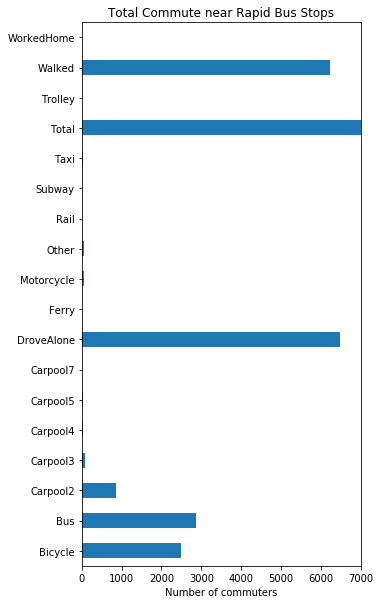

In [217]:
data.sort_values(by="Bus", ascending=False)
data1 = copy.deepcopy(data)
data1.drop('DES_ID', axis=1, inplace=True)
data1.drop('DES_ID_1', axis=1, inplace=True)
data1.drop('DES_LENGTH', axis=1, inplace=True)
data1.drop('OBJECTID_1', axis=1, inplace=True)
data1.drop('OBJECTID', axis=1, inplace=True)
data1.drop('ORG_DES_ID', axis=1, inplace=True)
data1.drop('ORG_DES_ID_1', axis=1, inplace=True)
data1.drop('ORG_ID', axis=1, inplace=True)
data1.drop('ORG_ID_1', axis=1, inplace=True)
data1.drop('RESIDENCE', axis=1, inplace=True)
data1.drop('ShapeSTLength', axis=1, inplace=True)
data1.drop('WORKPLACE', axis=1, inplace=True)
data1.drop('coordinates', axis=1, inplace=True)
data1=data1.sum()
print(data1)
fig, ax = subplots()
dataplot1=data1.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot1
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot1.set_xlabel("Number of commuters")

In [218]:
#eliminating people who have work 10 min distance from their home
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
dic20= []
dic30=[]
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
    
for index in data["OBJECTID"]:
    coordinates = data[data["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for coor in coordinates:                    
        lat1 = radians(float(coor[1]))
        lon1 = radians(float(coor[0]))
        lat2 = radians(float(coor[3]))
        lon2 = radians(float(coor[2]))
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        if 0.6 <= distance:
            dic.append(data[data["OBJECTID"]==index])
        if 1.2 <= distance:
            dic20.append(data[data["OBJECTID"]==index])
        if 1.8 <= distance:
            dic30.append(data[data["OBJECTID"]==index])            
data3=pd.concat(dic20)
data4=pd.concat(dic30)
data2=pd.concat(dic)
data2                    
            

        

Bicycle    Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                     
227           4.0    4.0      10.0       0.0       0.0       0.0       0.0   
228          30.0   10.0       4.0       4.0       0.0       0.0       0.0   
245           4.0    0.0       4.0       0.0       0.0       0.0       0.0   
259           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
266           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
268           4.0    0.0       0.0       0.0       0.0       0.0       0.0   
271           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
272           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
273           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
274           4.0    0.0       0.0       0.0       0.0       0.0       0.0   
275           4.0    0.0       0.0       0.0       0.0       0.0       0.0   
276           4.0    4.0       0.0       0.0       0.0       0.0       0.0   
277           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
278           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
279           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
286           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
292           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
308           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
316           0.0    0.0       0.0       0.0       4.0       0.0       0.0   
1593          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1606         95.0    0.0       0.0       0.0       0.0       0.0       0.0   
1623          0.0    0.0      15.0       0.0       0.0       0.0       0.0   
1637          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1644          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1646          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1649         25.0   10.0       0.0       0.0       0.0       0.0       0.0   
1650         40.0    0.0       0.0       0.0       0.0       0.0       0.0   
1651          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1652          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1653         10.0   10.0       0.0       0.0       0.0       0.0       0.0   
...           ...    ...       ...       ...       ...       ...       ...   
10237         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10238         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10239         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10240         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10241         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10242         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10243         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10244         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10251         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10257         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10280         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11027        50.0    0.0       0.0       0.0       0.0       0.0       0.0   
11040        40.0   35.0       0.0       0.0       0.0       0.0       0.0   
11041       120.0  145.0      55.0       0.0       0.0       0.0       0.0   
11058         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11072         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11079         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11081         0.0    0.0      10.0       0.0       0.0       0.0       0.0   
11084         0.0   15.0       0

Bicycle        2414.0
Bus            2857.0
Carpool2        837.0
Carpool3         94.0
Carpool4         34.0
Carpool5         40.0
Carpool7         15.0
DroveAlone     6339.0
Ferry            15.0
Motorcycle       58.0
Other            69.0
Rail              0.0
Subway            0.0
Taxi             40.0
Total         18759.0
Trolley           0.0
Walked         5949.0
WorkedHome        0.0
dtype: float64


Text(0.5, 0, 'Number of commuters')

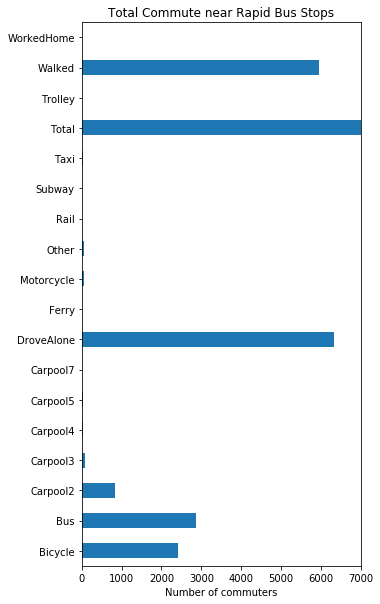

In [219]:
data2.sort_values(by="Bus", ascending=False)
data2 = copy.deepcopy(data2)
data2.drop('DES_ID', axis=1, inplace=True)
data2.drop('DES_ID_1', axis=1, inplace=True)
data2.drop('DES_LENGTH', axis=1, inplace=True)
data2.drop('OBJECTID_1', axis=1, inplace=True)
data2.drop('OBJECTID', axis=1, inplace=True)
data2.drop('ORG_DES_ID', axis=1, inplace=True)
data2.drop('ORG_DES_ID_1', axis=1, inplace=True)
data2.drop('ORG_ID', axis=1, inplace=True)
data2.drop('ORG_ID_1', axis=1, inplace=True)
data2.drop('RESIDENCE', axis=1, inplace=True)
data2.drop('ShapeSTLength', axis=1, inplace=True)
data2.drop('WORKPLACE', axis=1, inplace=True)
data2.drop('coordinates', axis=1, inplace=True)
data2=data2.sum()
print(data2)
fig, ax = subplots()
dataplot2=data2.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot2
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot2.set_xlabel("Number of commuters")

Bicycle        2029.0
Bus            2642.0
Carpool2        818.0
Carpool3         94.0
Carpool4         34.0
Carpool5         40.0
Carpool7         15.0
DroveAlone     6174.0
Ferry            15.0
Motorcycle       58.0
Other            69.0
Rail              0.0
Subway            0.0
Taxi             40.0
Total         16039.0
Trolley           0.0
Walked         4019.0
WorkedHome        0.0
dtype: float64


Text(0.5, 0, 'Number of commuters')

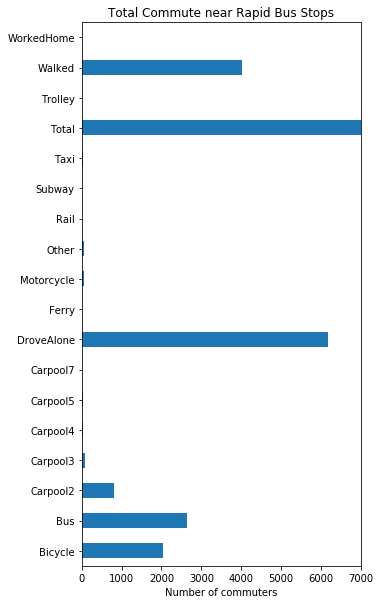

In [220]:
data3.sort_values(by="Bus", ascending=False)
data3 = copy.deepcopy(data3)
data3.drop('DES_ID', axis=1, inplace=True)
data3.drop('DES_ID_1', axis=1, inplace=True)
data3.drop('DES_LENGTH', axis=1, inplace=True)
data3.drop('OBJECTID_1', axis=1, inplace=True)
data3.drop('OBJECTID', axis=1, inplace=True)
data3.drop('ORG_DES_ID', axis=1, inplace=True)
data3.drop('ORG_DES_ID_1', axis=1, inplace=True)
data3.drop('ORG_ID', axis=1, inplace=True)
data3.drop('ORG_ID_1', axis=1, inplace=True)
data3.drop('RESIDENCE', axis=1, inplace=True)
data3.drop('ShapeSTLength', axis=1, inplace=True)
data3.drop('WORKPLACE', axis=1, inplace=True)
data3.drop('coordinates', axis=1, inplace=True)
data3=data3.sum()
print(data3)
fig, ax = subplots()
dataplot3=data3.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot3
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot3.set_xlabel("Number of commuters")

Bicycle        1339.0
Bus            1983.0
Carpool2        698.0
Carpool3         94.0
Carpool4         34.0
Carpool5          0.0
Carpool7         15.0
DroveAlone     5525.0
Ferry            15.0
Motorcycle       43.0
Other            69.0
Rail              0.0
Subway            0.0
Taxi             40.0
Total         11164.0
Trolley           0.0
Walked         1299.0
WorkedHome        0.0
dtype: float64


Text(0.5, 0, 'Number of commuters')

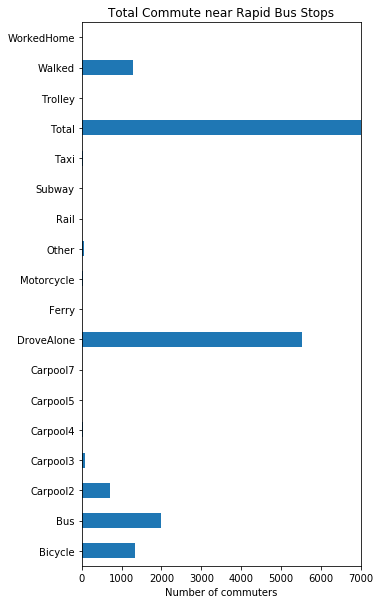

In [221]:
data4.sort_values(by="Bus", ascending=False)
data4 = copy.deepcopy(data4)
datafour = copy.deepcopy(data4)
data4.drop('DES_ID', axis=1, inplace=True)
data4.drop('DES_ID_1', axis=1, inplace=True)
data4.drop('DES_LENGTH', axis=1, inplace=True)
data4.drop('OBJECTID_1', axis=1, inplace=True)
data4.drop('OBJECTID', axis=1, inplace=True)
data4.drop('ORG_DES_ID', axis=1, inplace=True)
data4.drop('ORG_DES_ID_1', axis=1, inplace=True)
data4.drop('ORG_ID', axis=1, inplace=True)
data4.drop('ORG_ID_1', axis=1, inplace=True)
data4.drop('RESIDENCE', axis=1, inplace=True)
data4.drop('ShapeSTLength', axis=1, inplace=True)
data4.drop('WORKPLACE', axis=1, inplace=True)
data4.drop('coordinates', axis=1, inplace=True)
data4=data4.sum()
print(data4)
fig, ax = subplots()
dataplot4=data4.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot4
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot4.set_xlabel("Number of commuters")

In [222]:
#number of commute comparrason 
stack=pd.concat([data1, data2, data3, data4],axis=1, join_axes=[data1.index])
stack=pd.DataFrame(stack)
stack.columns = ['None', '10 min', '20 min', "30 min"]
stack=stack.transpose()

stack.drop('Total', axis=1, inplace=True)

stack10min = copy.deepcopy(stack) 

In [223]:
stack.drop('Rail', axis=1, inplace=True)
stack.drop('Other', axis=1, inplace=True)
stack.drop('Motorcycle', axis=1, inplace=True)
stack.drop('Ferry', axis=1, inplace=True)
stack.drop('Carpool7', axis=1, inplace=True)
stack.drop('Carpool5', axis=1, inplace=True)
stack.drop('Carpool4', axis=1, inplace=True)
stack.drop('WorkedHome', axis=1, inplace=True)
stack.drop('Trolley', axis=1, inplace=True)
stack.drop('Taxi', axis=1, inplace=True)
stack.drop('Subway', axis=1, inplace=True)

Text(0.5, 0, 'Number of commuters')

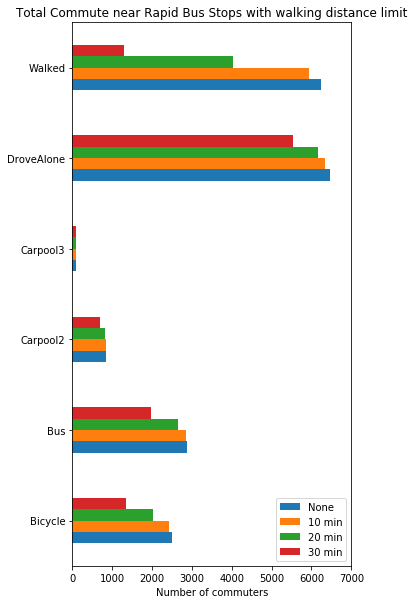

In [224]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops with walking distance limit",xlim=(0,7000), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [230]:
#percentage of commute 
data1=data1/data1["Total"]
data2=data2/data2["Total"]
data3=data3/data3["Total"]
data4=data4/data4["Total"]
stack=pd.concat([data1, data2, data3, data4],axis=1, join_axes=[data1.index])
stack=pd.DataFrame(stack)
stack.columns = ['Total', '10 min', '20 min', "30 min"]
stack=stack.transpose()
stack.drop('Total', axis=1, inplace=True)
stack10minper = copy.deepcopy(stack)

In [231]:
stack.drop('WorkedHome', axis=1, inplace=True)
stack.drop('Trolley', axis=1, inplace=True)
stack.drop('Taxi', axis=1, inplace=True)
stack.drop('Subway', axis=1, inplace=True)

stack.drop('Rail', axis=1, inplace=True)
stack.drop('Other', axis=1, inplace=True)
stack.drop('Motorcycle', axis=1, inplace=True)
stack.drop('Ferry', axis=1, inplace=True)
stack.drop('Carpool7', axis=1, inplace=True)
stack.drop('Carpool5', axis=1, inplace=True)
stack.drop('Carpool4', axis=1, inplace=True)

Text(0.5, 0, 'Number of commuters')

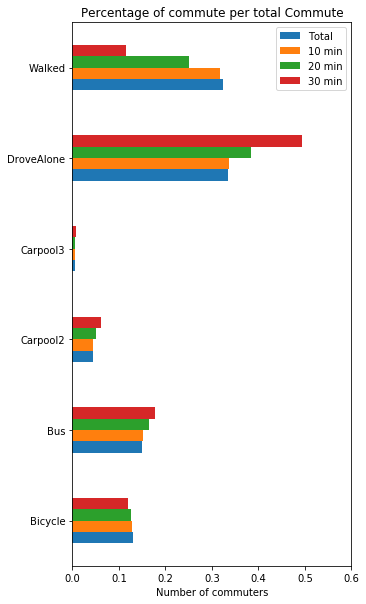

In [232]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Percentage of commute per total Commute",xlim=(0,0.6), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [233]:
misc=-(stack.transpose().sum()-1)
stack["Misc"] = misc


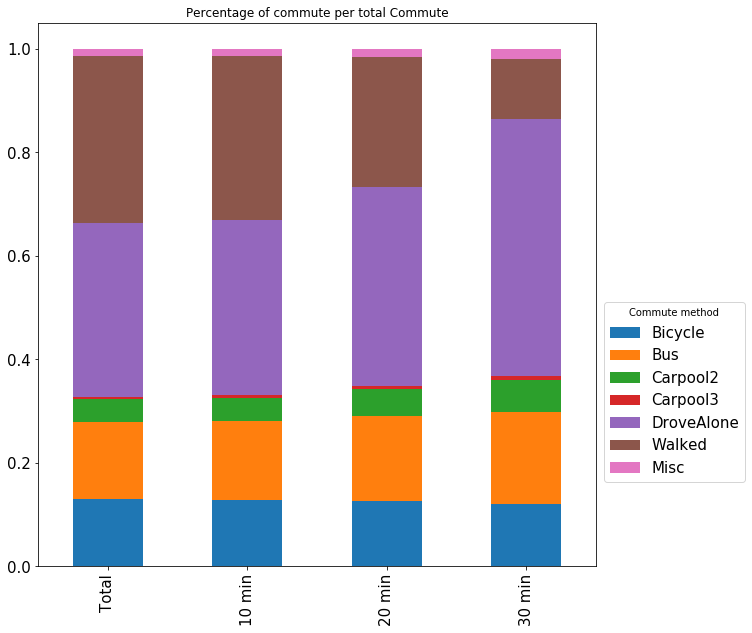

In [235]:
fig, ax = subplots()
stackplot=stack.transpose().T.plot.bar(figsize=(10,10),xlim=(0,1.0), stacked= True, title="Percentage of commute per total Commute", fontsize=15, ax=ax)
stackplot.legend(title='Commute method', bbox_to_anchor=(1, 0.5), fontsize = 15)


In [26]:
import pandas as pd
import geopandas # we'll use this to read shapefiles
from shapely.geometry import Point

# the City_Limit directory contains some shapefiles.
# downloaded from here: http://data-cityofmadison.opendata.arcgis.com/datasets/city-limit
madison = geopandas.read_file("City_Limit")
madison.head()


OBJECTID    SHAPESTAre    SHAPESTLen  \
0      1312  5.274004e+05  3.378551e+03   
1      1313  2.675664e+04  7.126214e+02   
2      1314  1.488101e+05  3.297256e+03   
3      1315  2.259798e+09  1.133896e+06   

                                            geometry  
0  POLYGON ((-89.36924133213829 43.10153277072625...  
1  POLYGON ((-89.28523345356945 43.02112710884431...  
2  POLYGON ((-89.28049139471618 43.11701006709443...  
3  POLYGON ((-89.5331291634087 43.0857426328395, ...

In [27]:
# downloaded from here: http://data-cityofmadison.opendata.arcgis.com/datasets/c46082b091a941f8b2ded1dd115a1a05_8
lakes = geopandas.read_file("Lakes_and_Rivers")
lakes.head()

OBJECTID    SHAPESTAre  SHAPESTLen  \
0         1  39958.447479  782.327754   
1         2  31880.854431  797.842450   
2         3   3699.958649  814.712984   
3         4   1174.258911  797.157265   
4         5  40693.432434  848.431555   

                                            geometry  
0  POLYGON ((-89.49887223021146 43.08164301711978...  
1  POLYGON ((-89.48481873925945 43.08431142416414...  
2  POLYGON ((-89.51718402551259 43.10277473207884...  
3  POLYGON ((-89.5186932397623 43.10267727786282,...  
4  POLYGON ((-89.54301597807076 43.10090510287239...

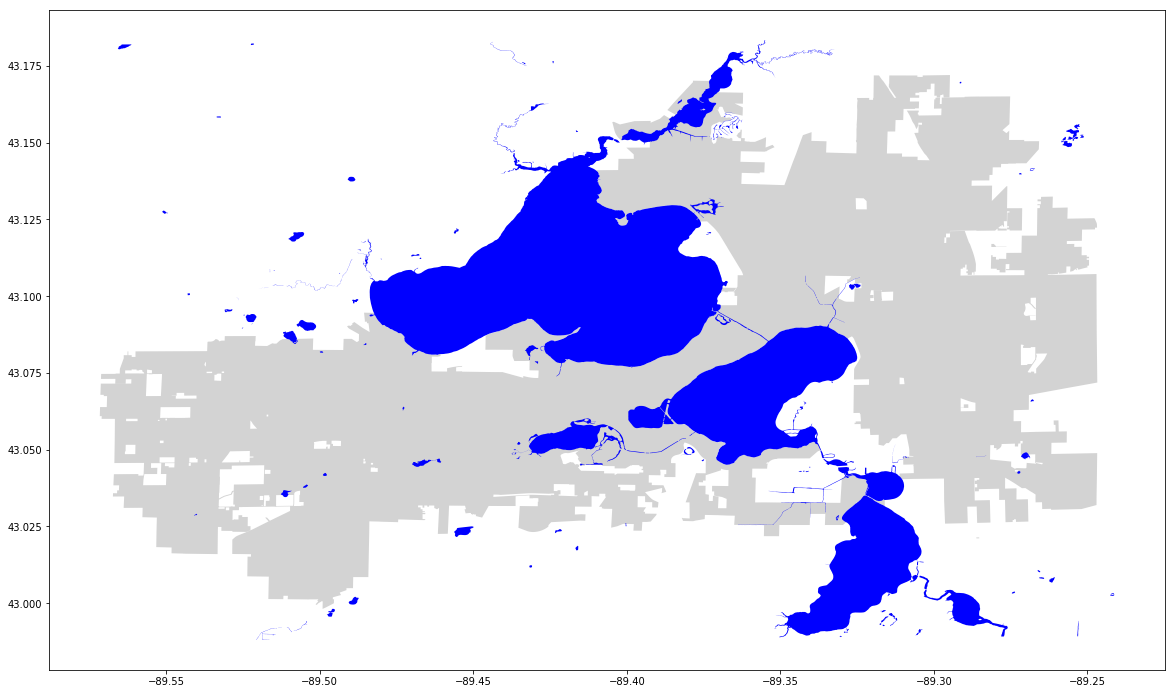

In [28]:
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)

In [29]:
# now lets annotate some buildings
coords = pd.Series([
    Point(-89.406749, 43.071478), # CS building
    Point(-89.384054, 43.074617), # Capital
])
print(coords)
buildings = pd.DataFrame({"Coordinates": coords})
buildings = geopandas.GeoDataFrame(buildings, geometry='Coordinates')
buildings

0            POINT (-89.406749 43.071478)
1    POINT (-89.38405400000001 43.074617)
dtype: object


Coordinates
0          POINT (-89.406749 43.071478)
1  POINT (-89.38405400000001 43.074617)

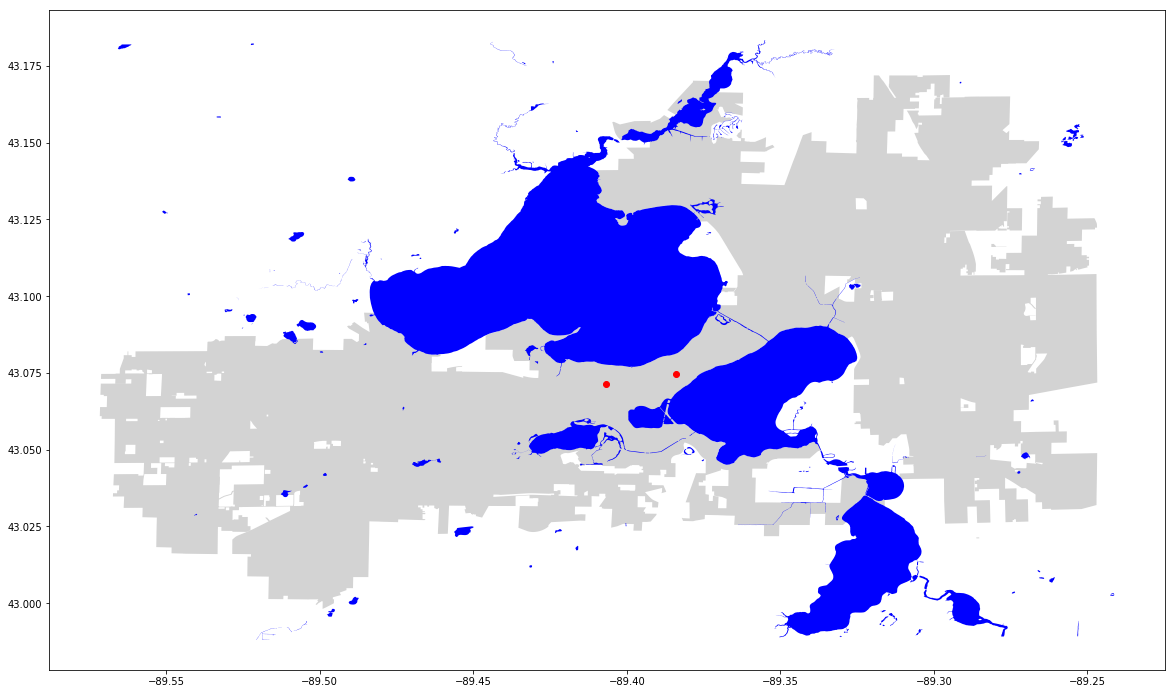

In [30]:
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
buildings.plot(color="red", ax=ax)

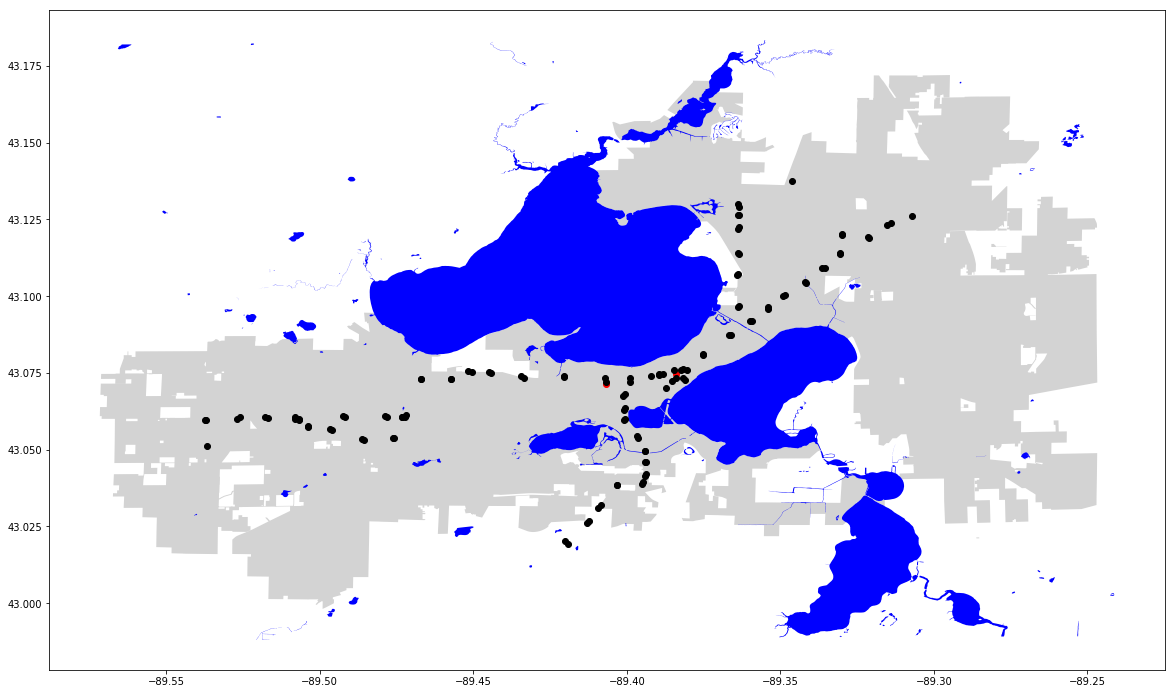

In [31]:
#annotate rapid bus stops 
dic = []
for coor in rbusdata["coordinates"]:
    dic.append(Point(float(coor[0]),float(coor[1])))
coords = pd.Series(dic)
bs = pd.DataFrame({"Coordinates": coords})
bs = geopandas.GeoDataFrame(bs, geometry='Coordinates')


ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
buildings.plot(color="red", ax=ax)
bs.plot(color="black", ax=ax)

In [32]:
homedic = []
for coor in data["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hcoords.head()

0    POINT (-89.4487037217782 43.07901968394355)
1    POINT (-89.4487037217782 43.07901968394355)
2    POINT (-89.4487037217782 43.07901968394355)
3    POINT (-89.4487037217782 43.07901968394355)
4    POINT (-89.4487037217782 43.07901968394355)
dtype: object

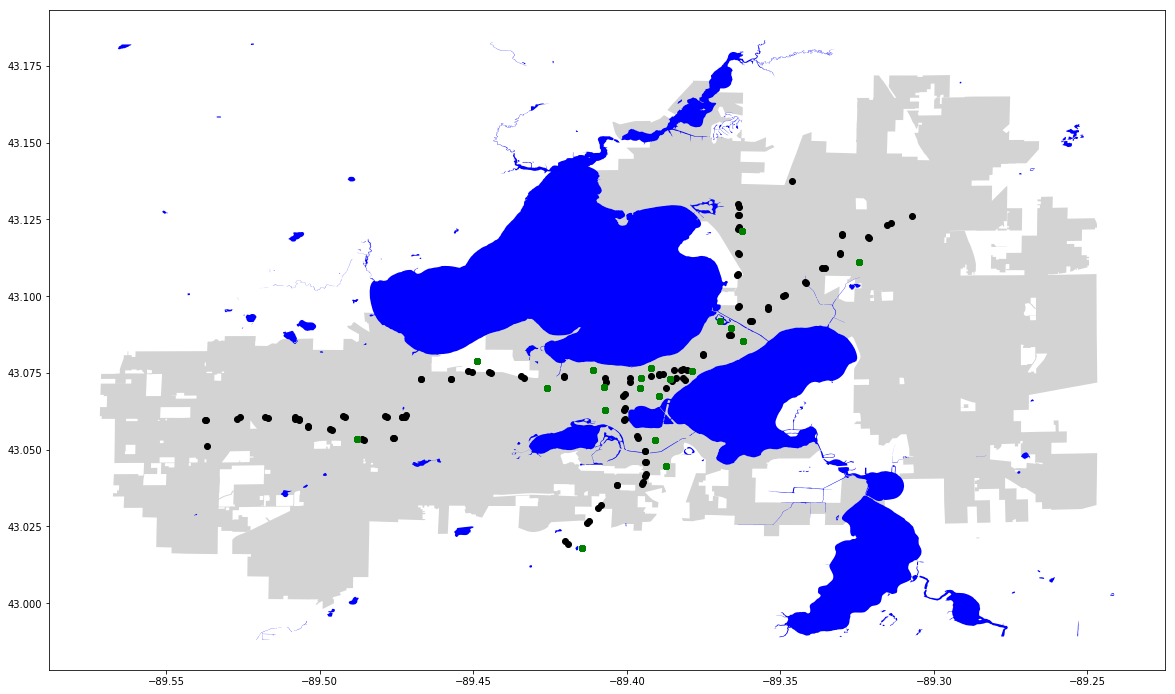

In [33]:
#annotate commute data  
homedic = []
for coor in data["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in data["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)


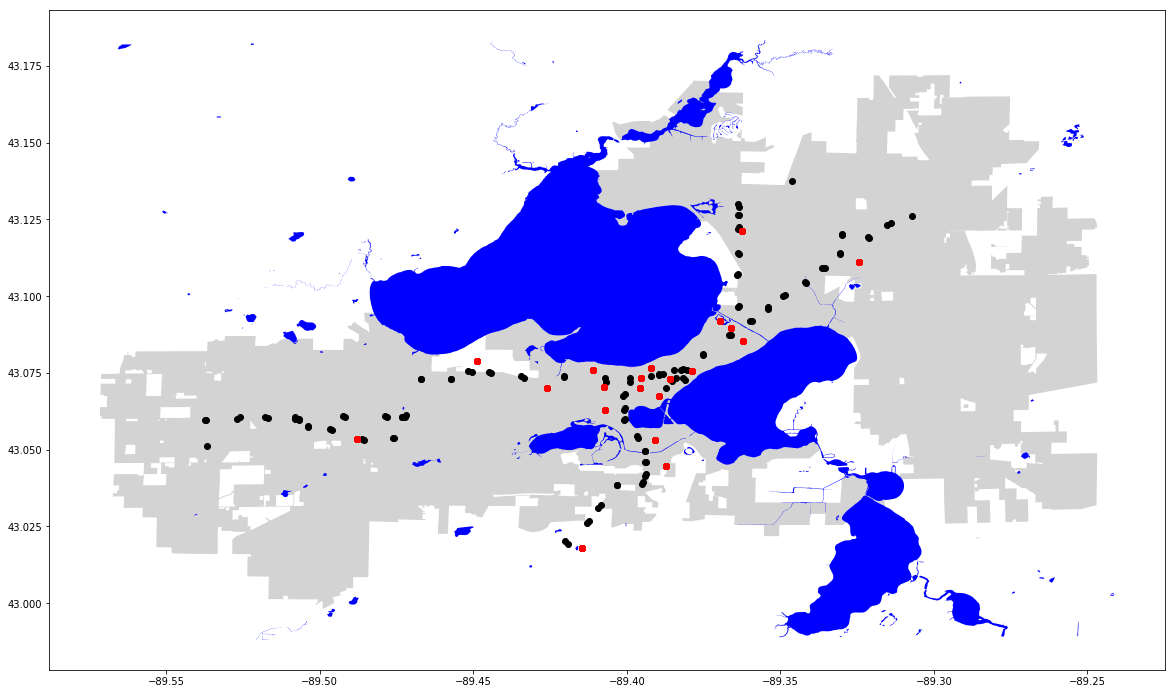

In [34]:
#annotate commute data  
homedic = []
for coor in data["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in data["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)
ws.plot(color="red", ax=ax)
#apparently, the work place and home coordinates are exactly the same so it overlaps, 
#only making one of the colors show... what?!

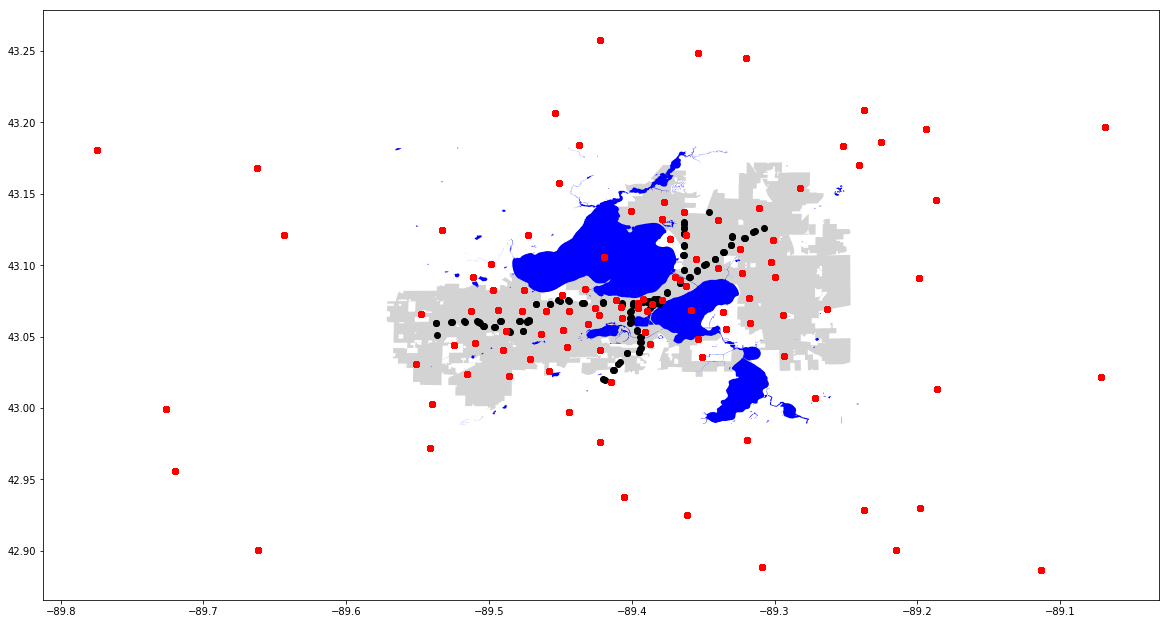

In [35]:
#annotate commute data from the origional wpdata
homedic = []
for coor in wpdata["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in wpdata["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)
ws.plot(color="red", ax=ax)
#again did not print due to the overlap. What is going on?? 

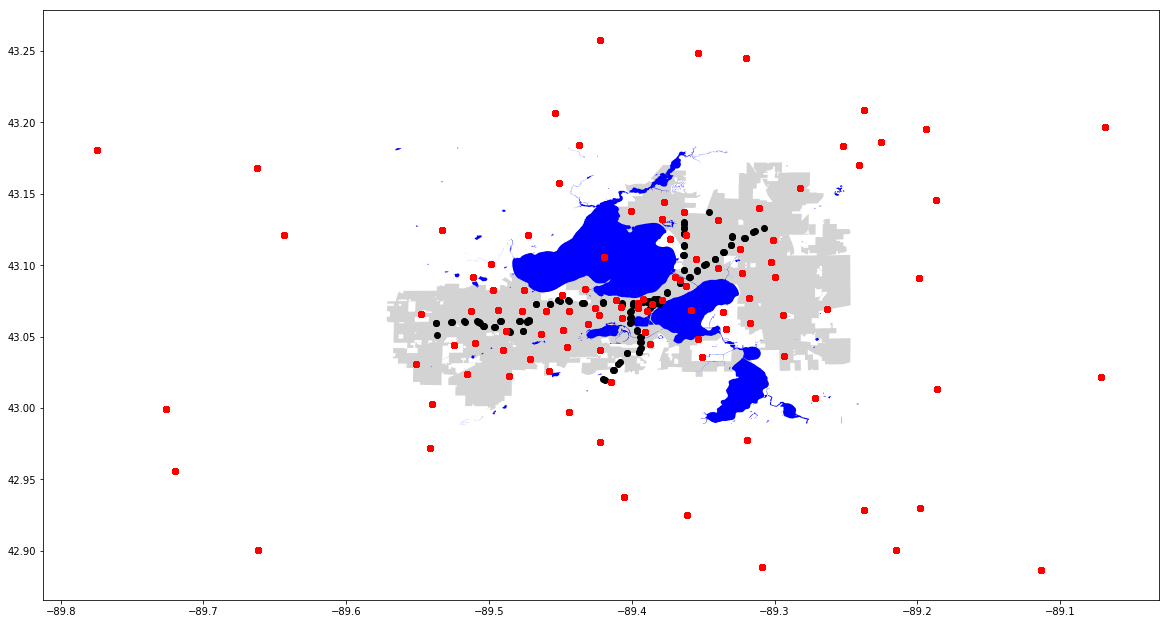

In [36]:
#annotate commute data from the origional wpdata
homedic = []
for coor in wpdata["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in wpdata["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)
ws.plot(color="red", ax=ax)
#again did not print due to the overlap. What is going on?? 

380


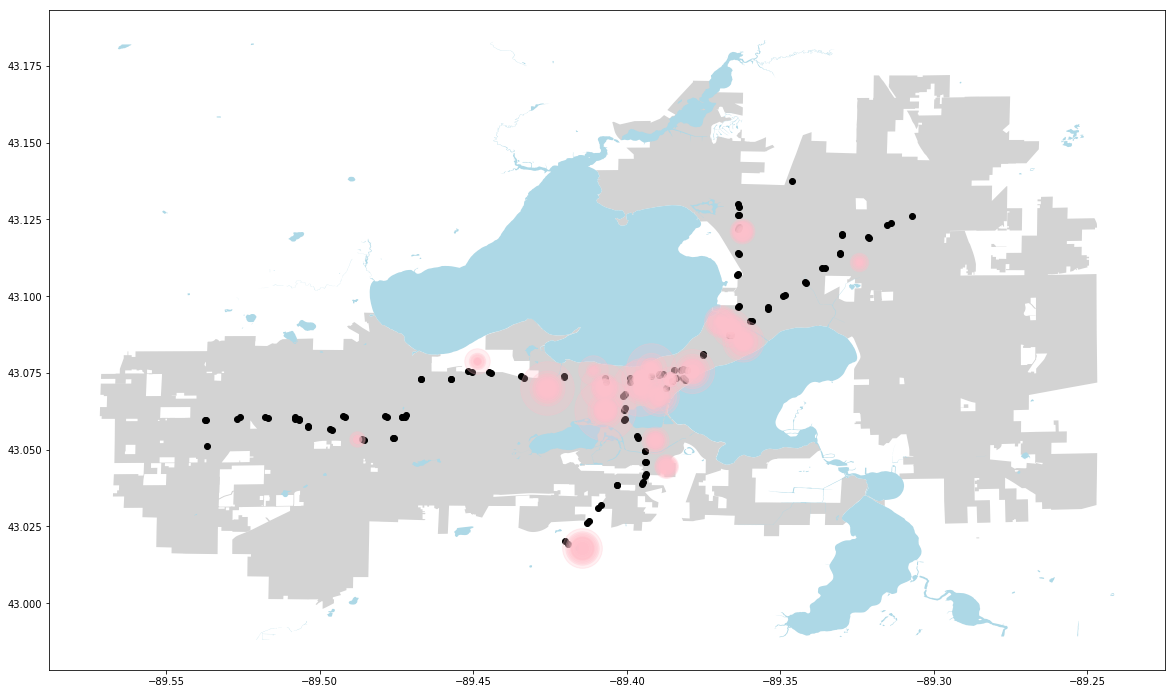

In [37]:
#annotate commute data from the origional wpdata
#making the dots bigger according to travel size 
#reference_____https://pynative.com/python-generate-random-string/
#reference_____http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
#mport random
#import string
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
print(len(data))
data.fillna(0, inplace=True)
dic = range(0, 380)
dic = list(dic)
i = 0
for index in data["OBJECTID"]:
    locat = data[data["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic = []
        homedic.append(Point(float(coor[0]),float(coor[1])))
        hcoords = pd.Series(homedic)
        hs = pd.DataFrame({"Coordinates": hcoords})
        hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
        total = locat["Total"]
        pop=float(total)*5
        dic[i] = hs
        #print(pop)
        #lettersAndDigits = string.ascii_letters + string.digits
        #counter =''.join(random.choice(lettersAndDigits) for i in range(10))
        #counter = hs
        dic[i].plot(color="pink", ax=ax, markersize=pop, alpha=0.25)
        i += 1
        

        
         
    
    


 


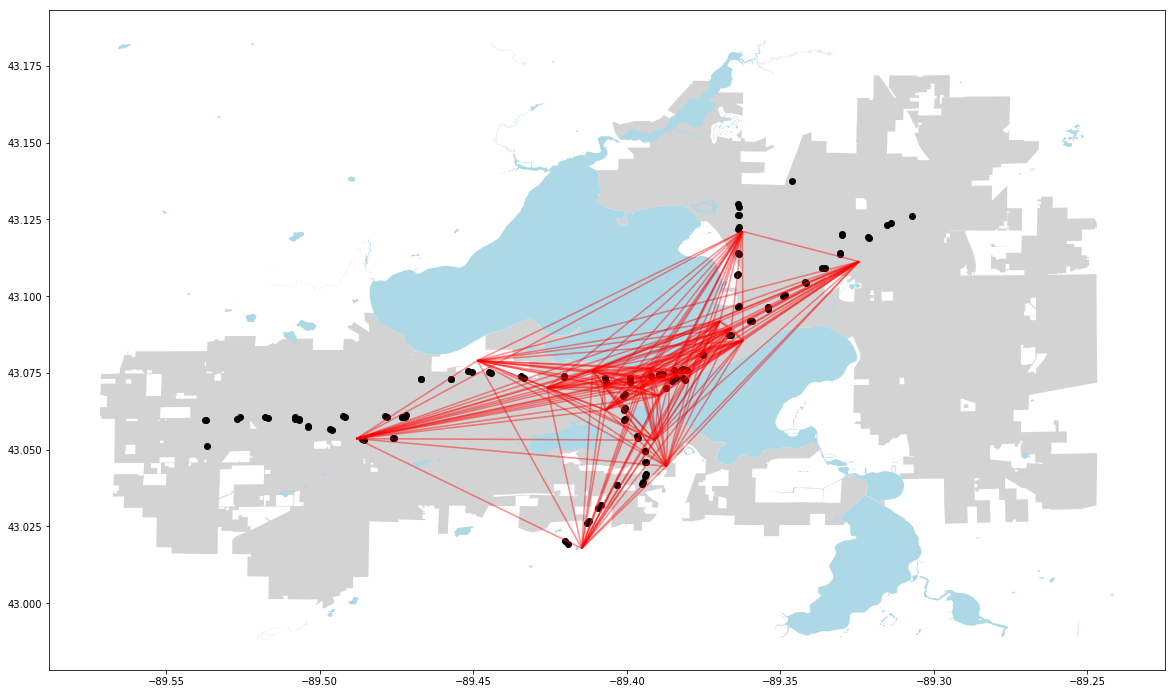

In [38]:
#################draw lines between the two coordinates to check relevence######################

#making the dots bigger according to travel size 
#reference_____https://pynative.com/python-generate-random-string/
#reference_____http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
#import random
#import string
from shapely.geometry import LineString

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)

data.fillna(0, inplace=True)
homedic = []
for index in data["OBJECTID"]:
    locat = data[data["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic.append(LineString([(float(coor[0]), float(coor[1])), (float(coor[2]), float(coor[3]))]))     
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.25)

        

In [39]:
#cleaning up NaN in origional wpdata
wpdata.fillna(0, inplace=True)
wpdata.head()

Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                    
1             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
2             0.0  25.0       0.0       0.0       0.0       0.0       0.0   
3             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
4             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5             0.0   0.0       0.0       0.0       0.0       0.0       0.0   

          DES_ID  DES_ID_1    DES_LENGTH  ...  Rail  ShapeSTLength  Subway  \
OBJECTID                                  ...                                
1           10.0      10.0  14888.338340  ...   0.0   14888.338340     0.0   
2          101.0     101.0   7271.941348  ...   0.0    7271.941348     0.0   
3          102.0     102.0  30090.845436  ...   0.0   30090.845436     0.0   
4          103.0     103.0  37615.520001  ...   0.0   37615.520001     0.0   
5          104.0     104.0  39009.663787  ...   0.0   39009.663787     0.0   

          Taxi  Total Trolley                                 WORKPLACE  \
OBJECTID                                                                  
1          0.0   10.0     0.0   Census Tract 10, Dane County, Wisconsin   
2          0.0   35.0     0.0  Census Tract 101, Dane County, Wisconsin   
3          0.0    0.0     0.0  Census Tract 102, Dane County, Wisconsin   
4          0.0    0.0     0.0  Census Tract 103, Dane County, Wisconsin   
5          0.0    0.0     0.0  Census Tract 104, Dane County, Wisconsin   

          Walked  WorkedHome  \
OBJECTID                       
1            0.0         0.0   
2            0.0         0.0   
3            0.0         0.0   
4            0.0         0.0   
5            0.0         0.0   

                                                coordinates  
OBJECTID                                                     
1         [-89.47539185715189, 43.08293455103483, -89.43...  
2         [-89.47539185715189, 43.08293455103483, -89.44...  
3         [-89.47539185715189, 43.08293455103483, -89.37...  
4         [-89.47539185715189, 43.08293455103483, -89.33...  
5         [-89.47539185715189, 43.08293455103483, -89.33...  

[5 rows x 31 columns]

In [40]:
#commuting from entire wpdata 
from shapely.geometry import LineString


homedic = []
for index in wpdata["OBJECTID"]:
    locat = wpdata[wpdata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic.append(LineString([(float(coor[0]), float(coor[1])), (float(coor[2]), float(coor[3]))]))             


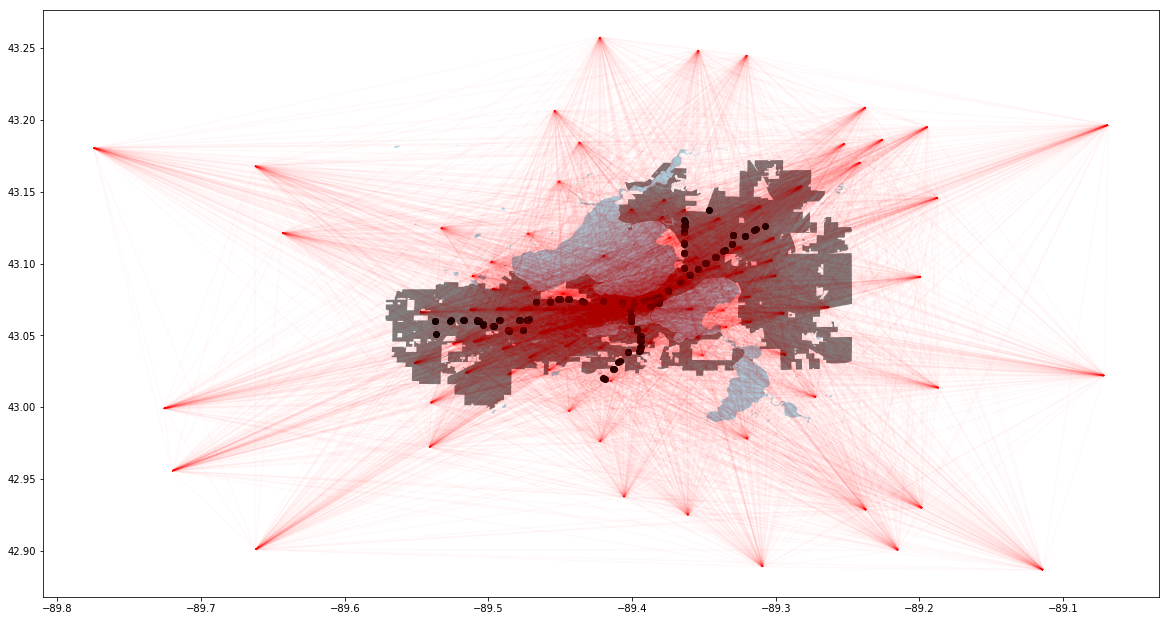

In [41]:
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.01)

In [42]:
import random
import string
lettersAndDigits = string.ascii_letters + string.digits
count=''.join(random.choice(lettersAndDigits) for i in range(10))
count

'sNXqR05rw5'

In [43]:
#http://data-cityofmadison.opendata.arcgis.com/datasets/3afa8d889c8541ec8cbd89c5845921a2_26
#2015 ridership data by stops

res = requests.get("https://opendata.arcgis.com/datasets/3afa8d889c8541ec8cbd89c5845921a2_26.geojson")
j = res.json()
dic= []
for object in j["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("rideship2015.csv", encoding='utf-8', index=False)            #
ride15=pd.read_csv("rideship2015.csv")
ride15=ride15.set_index(ride15["OBJECTID"])
ride15

DotSize  IntersectionID        Lat        Lon  OBJECTID  Saturday  \
OBJECTID                                                                        
8294       20664.92             564  43.125730 -89.349732      8294      0.00   
8295       53519.45             588  43.135627 -89.315817      8295      2.50   
8296       15890.11             576  43.132754 -89.287898      8296      2.52   
8297           0.00            1008  43.142573 -89.284234      8297      0.00   
8298         558.51             136  43.131871 -89.347168      8298      0.00   
8299        1672.48             150  43.131605 -89.303456      8299      0.50   
8300       21223.43             891  43.121095 -89.315580      8300      4.00   
8301       18832.72             597  43.144008 -89.295464      8301      3.02   
8302      111580.24             556  43.120882 -89.306933      8302     10.06   
8303         558.51             942  43.120655 -89.337039      8303      0.00   
8304      144948.50             570  43.130465 -89.310228      8304      4.50   
8305        7804.92             159  43.142305 -89.303289      8305      1.00   
8306       83716.68             553  43.117430 -89.323306      8306      8.00   
8307      239165.03             920  43.109372 -89.335929      8307     24.52   
8308      402677.97             888  43.118826 -89.321909      8308     48.53   
8309       16755.34             563  43.123627 -89.351847      8309      0.00   
8310       11202.19             885  43.112332 -89.330638      8310      0.00   
8311       42927.06             568  43.128772 -89.309428      8311      6.51   
8312        2248.84             179  43.103793 -89.300429      8312      0.00   
8313       59133.04             888  43.118942 -89.321031      8313     14.50   
8314       17655.68             162  43.143923 -89.291065      8314      0.00   
8315       11149.88             892  43.123735 -89.313995      8315      1.00   
8316       26764.07             896  43.127957 -89.308713      8316      2.50   
8317       10042.22             534  43.106564 -89.305043      8317      2.01   
8318           0.00             605  43.152299 -89.286538      8318      0.00   
8319       20239.52             178  43.102625 -89.296084      8319      0.00   
8320        1765.57             574  43.132398 -89.290345      8320      0.00   
8321       65992.37             153  43.127889 -89.293665      8321      3.50   
8322       18968.64            1018  43.108380 -89.314377      8322      6.03   
8323        6697.39             603  43.150261 -89.290014      8323      0.00   
...             ...             ...        ...        ...       ...       ...   
8264       46272.02             550  43.114292 -89.329055      8264      1.00   
8265         588.52             572  43.130664 -89.302148      8265      0.00   
8266        7650.79             158  43.134323 -89.290156      8266      2.52   
8267       11844.78             572  43.130690 -89.301814      8267      2.01   
8268       31919.52             874  43.106146 -89.330795      8268      6.04   
8269       84218.24             895  43.125413 -89.330324      8269      0.00   
8270       40726.79             548  43.113620 -89.296274      8270      3.52   
8271       18978.19             565  43.125470 -89.322961      8271      4.50   
8272       21744.89             885  43.113711 -89.330711      8272      3.50   
8273       13404.27             559  43.121954 -89.353591      8273      2.50   
8274           0.00             942  43.120547 -89.337397      8274      0.00   
8275       15063.33             882  43.109935 -89.310114      8275      4.02   
8276        9784.52             897  43.129090 -89.304300      8276      0.50   
8277       62439.35             159  43.142519 -89.302918      8277      3.00   
8278       13958.28             885  43.113962 -89.330488      8278      0.00   
8279        3531.14             158  43.134350 -89.290478      8279      0.00   
8280       28452.96             545  43.111

In [44]:
#http://data-cityofmadison.opendata.arcgis.com/items/3afa8d889c8541ec8cbd89c5845921a2
#2017 ridership data by stops

res = requests.get("https://maps.cityofmadison.com/arcgis/rest/services/Public/OPEN_DATA_TRANS/MapServer/26/query?outFields=*&where=1%3D1&f=geojson")
j = res.json()
dic= []
for object in j["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("rideship2017.csv", encoding='utf-8', index=False)            #
ride17=pd.read_csv("rideship2017.csv")
ride17=ride17.set_index(ride17["OBJECTID"])
ride17

DotSize  IntersectionID        Lat        Lon  OBJECTID  \
OBJECTID                                                               
6294      7325645.99             109  43.038895 -89.394824      6294   
6295      7295144.06             133  43.113253 -89.358540      6295   
6296      9392708.69              69  43.053883 -89.475098      6296   
6297      5649169.04             199  43.098619 -89.322148      6297   
6298      2474759.08             148  43.126576 -89.306961      6298   
6299      2483209.05             761  43.073317 -89.394044      6299   
6300       194295.14             761  43.072404 -89.393143      6300   
6301      1589719.16             210  43.070947 -89.406982      6301   
6302      4681937.73              78  43.075933 -89.400154      6302   
6303        37800.37             784  43.075691 -89.396944      6303   
6304      3144420.02             759  43.071895 -89.397341      6304   
6305         8894.21              79  43.078482 -89.389820      6305   
6306        36131.20             776  43.074636 -89.412598      6306   
6307      3594662.19             784  43.075529 -89.397191      6307   
6308         6882.13             746  43.069442 -89.402267      6308   
6309      1263996.84             445  43.076131 -89.405660      6309   
6310        31685.61              37  43.075781 -89.403882      6310   
6311          573.51             424  43.069470 -89.403872      6311   
6312        31685.61            1007  43.076650 -89.407141      6312   
6313       839885.95              37  43.075996 -89.403660      6313   
6314       772069.90             755  43.070893 -89.403698      6314   
6315         9449.23             759  43.072172 -89.397625      6315   
6316        18342.62            1006  43.074330 -89.400784      6316   
6317      2060520.60             207  43.070820 -89.398650      6317   
6318       715373.62             754  43.070857 -89.401119      6318   
6319       701597.60             767  43.074150 -89.392328      6319   
6320        20567.85             789  43.076844 -89.392142      6320   
6321         3335.33             785  43.077515 -89.388055      6321   
6322       375205.27              78  43.075745 -89.400179      6322   
6323      4617189.17             204  43.073399 -89.401365      6323   
...              ...             ...        ...        ...       ...   
7264         7491.71             115  43.011746 -89.429801      7264   
7265        57504.92             308  43.031167 -89.458882      7265   
7266            0.00             623  43.016321 -89.423264      7266   
7267        24559.67             648  43.034339 -89.444732      7267   
7268        17307.31             965  43.036012 -89.452111      7268   
7269       116095.60             626  43.019624 -89.420341      7269   
7270         4451.62              89  43.032342 -89.452603      7270   
7271        10373.13             270  43.013966 -89.431688      7271   
7272        32704.03             279  43.019436 -89.418898      7272   
7273        13082.99             272  43.015047 -89.477671      7273   
7274       120513.38              90  43.032663 -89.457920      7274   
7275        49546.34             305  43.029970 -89.399738      7275   
7276            0.00             366  43.050500 -89.437246      7276   
7277        20098.81             965  43.035896 -89.452407      7277   
7278          576.29             985  43.007054 -89.403680      7278   
7279         3414.49             612  42.990501 -89.534012      7279   
7280       270981.81             639  43.030814 -89.414283      7280   
7281            0.00             328  43.037634 -89.446312      7281   
7282         3349.80             996  43.036074 -89.454270      7282   
7283        73948.91             296  43.026329 -89.413136      7283   
7284        20438.18             271  43.015257 -89.467027      7284   
7285        57504.92             230  43.034759 -89.448705      7285   
7286         7491.71             614  43.001353 -89.4

In [45]:
# preparing presentation 
# how do people get to work 
# how laxy are people when it comes to biking and walking
#which neighborhoods make the most use of public transportation
#if we could add one bus line, what would it be? 

In [46]:
#finding the biggest commute coordinates 
dic= []
dicc =[]
diccc= []
for i in data["coordinates"]:
    longitude = i[0]
    latitude = i[1]
    dic.append(longitude)
    diccc.append(latitude)

dic = pd.DataFrame(dic)
mindic = dic.min()
maxdic = dic.max()

diccc = pd.DataFrame(diccc)
mindiccc = diccc.min()
print(mindiccc)
maxdiccc = diccc.max()

coordinates=wpdata["coordinates"]
for i in coordinates:
    dicc.append(i)
dicc = pd.DataFrame(dicc)

mincoor =dicc[dicc[0]==str(mindic[0])]
mincoor['index1'] = mincoor.index

maxcoor = dicc[dicc[0]==str(maxdic[0])]
maxcoor["index1"] = maxcoor.index

mincoorlat =dicc[dicc[1]==str(mindiccc[0])]
mincoorlat['index1'] = mincoorlat.index
mincoorlat.head()
maxcoorlat = dicc[dicc[1]==str(maxdiccc[0])]
maxcoorlat["index1"] = maxcoorlat.index
maxcoorlat.head()

0    43.017886
dtype: float64


C:\cs301\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\cs301\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\cs301\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\cs301\lib\site-packages\i

0                   1                   2  \
7844  -89.36236944652443  43.121105967515604  -89.47539185715189   
7845  -89.36236944652443  43.121105967515604  -89.43051929259912   
7846  -89.36236944652443  43.121105967515604   -89.4487037217782   
7847  -89.36236944652443  43.121105967515604  -89.37354363947391   
7848  -89.36236944652443  43.121105967515604   -89.3362371674424   

                      3  index1  
7844  43.08293455103483    7844  
7845  43.05872359846184    7845  
7846  43.07901968394355    7846  
7847  43.11822277710774    7847  
7848  43.06733017894498    7848

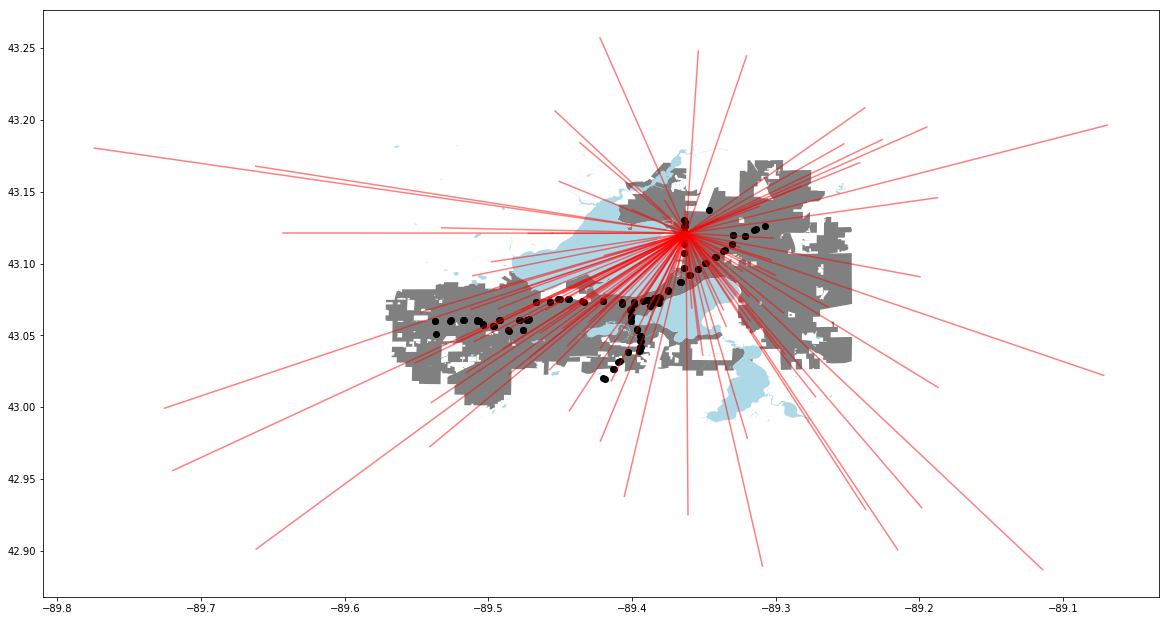

In [47]:
#most northern
from shapely.geometry import LineString


homedic = []
for index in maxcoorlat["index1"]:
    locat = maxcoorlat[maxcoorlat["index1"]==index]
    homedic.append(LineString([(locat[0], locat[1]), (locat[2], locat[3])]))             
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.5)    
    

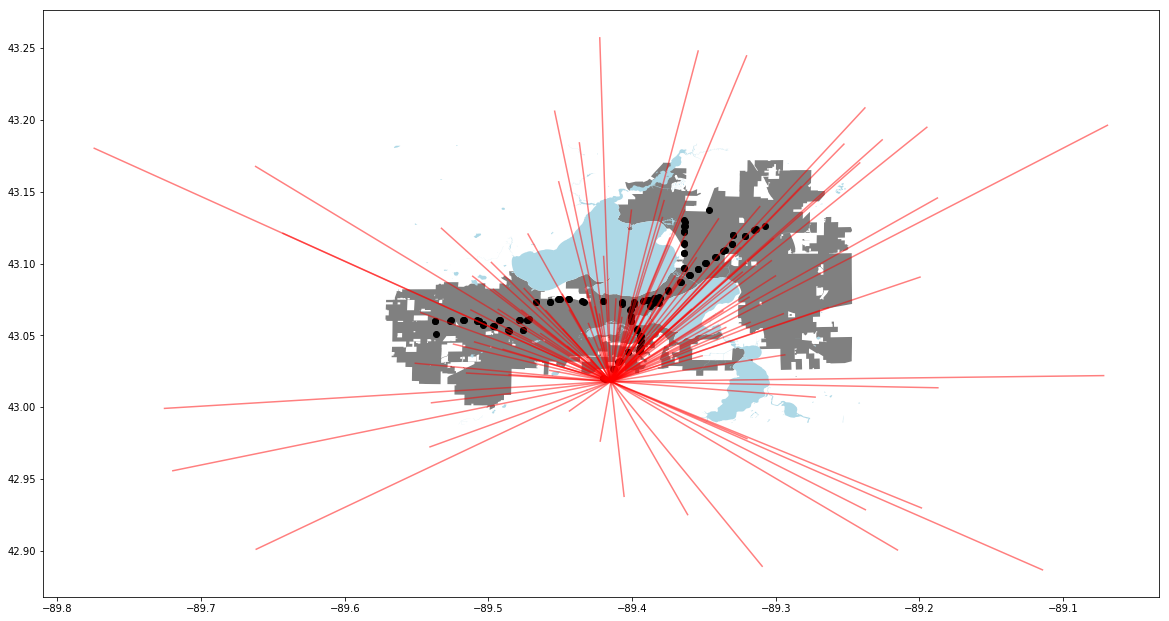

In [48]:
#most south
from shapely.geometry import LineString


homedic = []
for index in mincoorlat["index1"]:
    locat = mincoorlat[mincoorlat["index1"]==index]
    homedic.append(LineString([(locat[0], locat[1]), (locat[2], locat[3])]))             
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.5)    
    

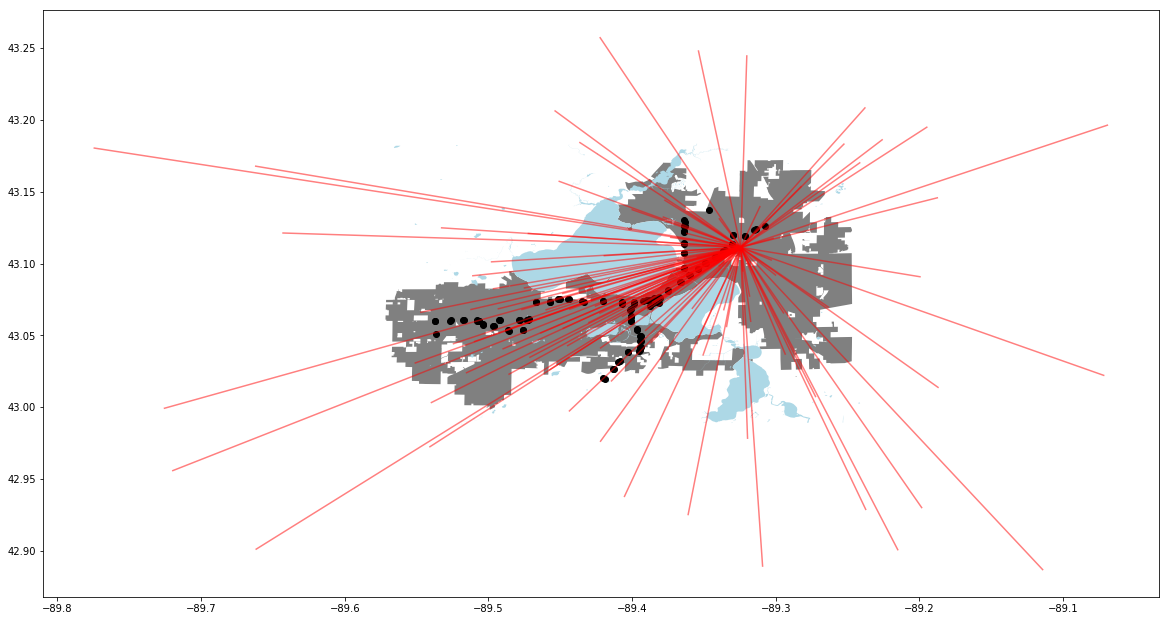

In [49]:
#most east
from shapely.geometry import LineString


homedic = []
for index in mincoor["index1"]:
    locat = mincoor[mincoor["index1"]==index]
    homedic.append(LineString([(locat[0], locat[1]), (locat[2], locat[3])]))             
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.5)    
    
             


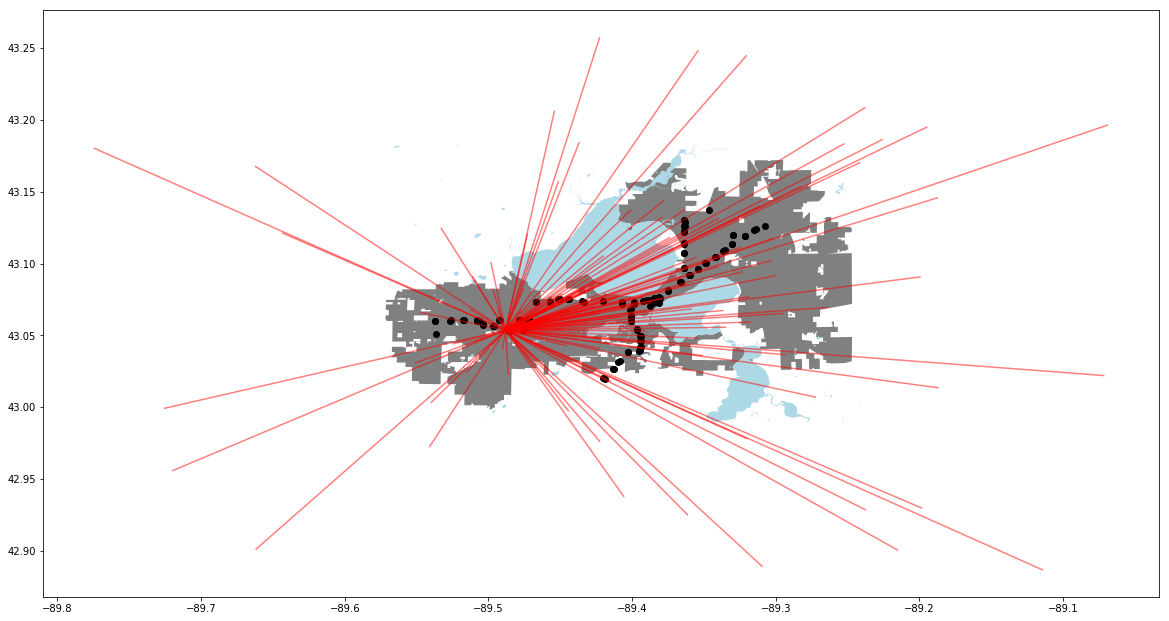

In [50]:
#most west
from shapely.geometry import LineString


homedic = []
for index in maxcoor["index1"]:
    locat = maxcoor[maxcoor["index1"]==index]
    homedic.append(LineString([(locat[0], locat[1]), (locat[2], locat[3])]))             
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.5)
    
    
    
 

In [51]:
wpdata

Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                    
1             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
2             0.0  25.0       0.0       0.0       0.0       0.0       0.0   
3             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
4             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
6             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
7             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
8             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
9             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
12            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
13            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
14            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
15           30.0  25.0       4.0       0.0       0.0       0.0       0.0   
16            0.0  55.0       0.0       4.0       0.0       0.0       0.0   
17            0.0   0.0      15.0       0.0       0.0       0.0       0.0   
18            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
19            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
20            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
21            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
22            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
23            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
24            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
25            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
26            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
27            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
28            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
29            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
30            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
...           ...   ...       ...       ...       ...       ...       ...   
11313         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11314         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11315         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11316         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11317         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11318         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11319         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11320         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11321         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11322         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11323         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11324         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11325         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11326         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11327         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11328         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11329         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11330         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11331         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11332 

In [52]:
dic=[]
for i in wpdata["coordinates"]:
    dic.append(i)



In [53]:
fourmile=pd.read_csv("fourmile.csv")
fourmile

Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
0         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0  25.0       0.0       0.0       0.0       0.0       0.0   
2         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
4         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
6         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
7         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
8         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
9         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
12        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
13        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
14       30.0  25.0       4.0       0.0       0.0       0.0       0.0   
15        0.0  55.0       0.0       4.0       0.0       0.0       0.0   
16        0.0   0.0      15.0       0.0       0.0       0.0       0.0   
17        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
18        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
19        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
20        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
21        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
22        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
23        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
24        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
25        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
26        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
27        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
28        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
29        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
...       ...   ...       ...       ...       ...       ...       ...   
5235      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5236      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5237      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5238      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5239      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5240      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5241      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5242      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5243      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5244      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5245      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5246      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5247      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5248      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5249      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5250      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5251      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5252      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5253      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5254      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5255      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5256      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5257      0.0   0.0       0.0       0.0       0.0       0.0     

In [54]:
for coor in fourmile["coordinates"]:
    print(coor)
    coor = str(coor)
    coor = coor.replace("[", "")
    coor = coor.replace("]", "")
    coor = coor.replace(",", "")
    #coor = coor.replace("-", "")
    coor = coor.replace("'", "")
    coor = coor.split()
    coorr = [float(coor[0]), float(coor[1]), float(coor[2]), float(coor[3])]


['-89.47539185715189', '43.08293455103483', '-89.43051929259912', '43.05872359846184']
['-89.47539185715189', '43.08293455103483', '-89.4487037217782', '43.07901968394355']
['-89.47539185715189', '43.08293455103483', '-89.37354363947391', '43.11822277710774']
['-89.47539185715189', '43.08293455103483', '-89.3362371674424', '43.06733017894498']
['-89.47539185715189', '43.08293455103483', '-89.33424086820831', '43.055643304873655']
['-89.47539185715189', '43.08293455103483', '-89.29314957048034', '43.03648150416008']
['-89.47539185715189', '43.08293455103483', '-89.2720056753369', '43.00692881233553']
['-89.47539185715189', '43.08293455103483', '-89.31954799676403', '42.97785865395301']
['-89.47539185715189', '43.08293455103483', '-89.44396270418392', '42.99701306482397']
['-89.47539185715189', '43.08293455103483', '-89.42221993621061', '42.97585679693157']
['-89.47539185715189', '43.08293455103483', '-89.54013402636183', '43.002976665726955']
['-89.47539185715189', '43.08293455103483', 

['-89.35067864168589', '43.03586360301233', '-89.29423297611912', '43.06522994173975']
['-89.35067864168589', '43.03586360301233', '-89.43264690288619', '43.08335218880434']
['-89.35067864168589', '43.03586360301233', '-89.44834829731435', '43.05470941638769']
['-89.35067864168589', '43.03586360301233', '-89.46391657156478', '43.05146755144486']
['-89.35067864168589', '43.03586360301233', '-89.51008151959496', '43.0455421548443']
['-89.35067864168589', '43.03586360301233', '-89.5247986637955', '43.04400168939438']
['-89.35067864168589', '43.03586360301233', '-89.49021844961675', '43.04041150496162']
['-89.35067864168589', '43.03586360301233', '-89.48804385843933', '43.053604975746346']
['-89.35067864168589', '43.03586360301233', '-89.47151159573573', '43.0345093928346']
['-89.35067864168589', '43.03586360301233', '-89.48606502642467', '43.02270221822585']
['-89.35067864168589', '43.03586360301233', '-89.51565399055576', '43.02377196879565']
['-89.35067864168589', '43.03586360301233', '

['-89.49698495276299', '43.082379657389616', '-89.42221993621061', '42.97585679693157']
['-89.49698495276299', '43.082379657389616', '-89.54013402636183', '43.002976665726955']
['-89.49698495276299', '43.082379657389616', '-89.54750424154314', '43.06597321721638']
['-89.49698495276299', '43.082379657389616', '-89.55136914685653', '43.03059223759067']
['-89.49698495276299', '43.082379657389616', '-89.53307633123887', '43.12487262147506']
['-89.49698495276299', '43.082379657389616', '-89.40739003324718', '43.07056495589608']
['-89.49698495276299', '43.082379657389616', '-89.41116584233575', '43.075790615835125']
['-89.49698495276299', '43.082379657389616', '-89.51133417341711', '43.09143352588734']
['-89.49698495276299', '43.082379657389616', '-89.49830702444065', '43.10113925720311']
['-89.49698495276299', '43.082379657389616', '-89.47267590164418', '43.12096705792559']
['-89.49698495276299', '43.082379657389616', '-89.4511601696397', '43.15737306355968']
['-89.49698495276299', '43.0823

['-89.32283821884667', '43.09431263013957', '-89.39563303302576', '43.070141682561136']
['-89.32283821884667', '43.09431263013957', '-89.3860984031346', '43.07291875475244']
['-89.32283821884667', '43.09431263013957', '-89.37892230612321', '43.07551218140237']
['-89.32283821884667', '43.09431263013957', '-89.36972857092232', '43.09184643825339']
['-89.32283821884667', '43.09431263013957', '-89.36597082626064', '43.08957996582616']
['-89.32283821884667', '43.09431263013957', '-89.36217771270263', '43.08554991980867']
['-89.32283821884667', '43.09431263013957', '-89.47708791071538', '43.06782491613173']
['-89.32283821884667', '43.09431263013957', '-89.49356321971818', '43.06834581239838']
['-89.32283821884667', '43.09431263013957', '-89.51259475206362', '43.067881727648945']
['-89.32283821884667', '43.09431263013957', '-89.49698495276299', '43.082379657389616']
['-89.32283821884667', '43.09431263013957', '-89.33976994620932', '43.09802776728962']
['-89.32283821884667', '43.09431263013957

['-89.47151159573573', '43.0345093928346', '-89.43264690288619', '43.08335218880434']
['-89.47151159573573', '43.0345093928346', '-89.44834829731435', '43.05470941638769']
['-89.47151159573573', '43.0345093928346', '-89.46391657156478', '43.05146755144486']
['-89.47151159573573', '43.0345093928346', '-89.51008151959496', '43.0455421548443']
['-89.47151159573573', '43.0345093928346', '-89.5247986637955', '43.04400168939438']
['-89.47151159573573', '43.0345093928346', '-89.49021844961675', '43.04041150496162']
['-89.47151159573573', '43.0345093928346', '-89.48804385843933', '43.053604975746346']
['-89.47151159573573', '43.0345093928346', '-89.48606502642467', '43.02270221822585']
['-89.47151159573573', '43.0345093928346', '-89.51565399055576', '43.02377196879565']
['-89.47151159573573', '43.0345093928346', '-89.45784643454714', '43.02568849729366']
['-89.47151159573573', '43.0345093928346', '-89.44524834466871', '43.04258489226217']
['-89.47151159573573', '43.0345093928346', '-89.4438223

In [55]:
#data clean up 
dic = []
for coor in fourmile["coordinates"]:
    coor = str(coor)
    coor = coor.replace("[", "")
    coor = coor.replace("]", "")
    coor = coor.replace(",", "")
    coor = coor.replace("'", "")
    coor = coor.split()
    coorr = [float(coor[0]), float(coor[1]), float(coor[2]), float(coor[3])]
    dic.append(coorr)
fourmile["coordinates"] = dic
fourmile

Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
0         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0  25.0       0.0       0.0       0.0       0.0       0.0   
2         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
4         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
6         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
7         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
8         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
9         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
12        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
13        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
14       30.0  25.0       4.0       0.0       0.0       0.0       0.0   
15        0.0  55.0       0.0       4.0       0.0       0.0       0.0   
16        0.0   0.0      15.0       0.0       0.0       0.0       0.0   
17        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
18        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
19        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
20        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
21        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
22        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
23        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
24        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
25        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
26        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
27        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
28        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
29        0.0   0.0       0.0       0.0       0.0       0.0       0.0   
...       ...   ...       ...       ...       ...       ...       ...   
5235      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5236      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5237      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5238      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5239      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5240      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5241      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5242      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5243      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5244      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5245      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5246      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5247      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5248      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5249      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5250      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5251      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5252      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5253      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5254      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5255      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5256      0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5257      0.0   0.0       0.0       0.0       0.0       0.0     

In [56]:
for coor in fourmile["coordinates"]:
    print(coor[2])

-89.43051929259912
-89.4487037217782
-89.37354363947391
-89.3362371674424
-89.33424086820831
-89.29314957048034
-89.2720056753369
-89.31954799676403
-89.44396270418392
-89.42221993621061
-89.54013402636183
-89.54750424154314
-89.55136914685653
-89.53307633123887
-89.40739003324718
-89.41116584233575
-89.51133417341711
-89.49830702444065
-89.47267590164418
-89.4511601696397
-89.4367161517534
-89.26298300841516
-89.28197260299989
-89.25211335279911
-89.22544473916422
-89.24105102964236
-89.4069760746376
-89.39094727243585
-89.38712931573009
-89.42231015221031
-89.41467673587252
-89.3536425560347
-89.35067864168589
-89.39542886592693
-89.39223017919251
-89.3896333883637
-89.39563303302576
-89.3860984031346
-89.37892230612321
-89.36972857092232
-89.36597082626064
-89.36217771270263
-89.47708791071538
-89.49356321971818
-89.51259475206362
-89.49698495276299
-89.33976994620932
-89.35498847450728
-89.36236944652443
-89.37868152300673
-89.40035422962426
-89.37754398793685
-89.36317378150443
-8

-89.22544473916422
-89.24105102964236
-89.4069760746376
-89.39094727243585
-89.38712931573009
-89.41467673587252
-89.3536425560347
-89.35067864168589
-89.39542886592693
-89.39223017919251
-89.3896333883637
-89.39563303302576
-89.3860984031346
-89.37892230612321
-89.36972857092232
-89.36597082626064
-89.36217771270263
-89.47708791071538
-89.49356321971818
-89.51259475206362
-89.49698495276299
-89.33976994620932
-89.35498847450728
-89.36236944652443
-89.37868152300673
-89.40035422962426
-89.37754398793685
-89.36317378150443
-89.33952125118142
-89.32437481157999
-89.31075223252628
-89.30131269241855
-89.32283821884667
-89.31807323876595
-89.3173082352867
-89.46026404036155
-89.29970482837942
-89.30261933530066
-89.29423297611912
-89.43264690288619
-89.44834829731435
-89.46391657156478
-89.51008151959496
-89.5247986637955
-89.49021844961675
-89.48804385843933
-89.47151159573573
-89.48606502642467
-89.51565399055576
-89.45784643454714
-89.44524834466871
-89.4438223297087
-89.42277910804265


-89.42231015221031
-89.41467673587252
-89.3536425560347
-89.35067864168589
-89.39542886592693
-89.39223017919251
-89.3896333883637
-89.39563303302576
-89.3860984031346
-89.37892230612321
-89.36972857092232
-89.36597082626064
-89.36217771270263
-89.47708791071538
-89.49356321971818
-89.49698495276299
-89.33976994620932
-89.35498847450728
-89.36236944652443
-89.37868152300673
-89.40035422962426
-89.37754398793685
-89.36317378150443
-89.33952125118142
-89.32437481157999
-89.31075223252628
-89.30131269241855
-89.32283821884667
-89.31807323876595
-89.3173082352867
-89.46026404036155
-89.29970482837942
-89.30261933530066
-89.29423297611912
-89.43264690288619
-89.44834829731435
-89.46391657156478
-89.51008151959496
-89.5247986637955
-89.49021844961675
-89.48804385843933
-89.47151159573573
-89.48606502642467
-89.51565399055576
-89.45784643454714
-89.44524834466871
-89.4438223297087
-89.42277910804265
-89.42596636983808
-89.41980509106963
-89.3583455907738
-89.47539185715189
-89.43051929259912


-89.55136914685653
-89.53307633123887
-89.40739003324718
-89.41116584233575
-89.51133417341711
-89.49830702444065
-89.47267590164418
-89.4511601696397
-89.4367161517534
-89.26298300841516
-89.28197260299989
-89.25211335279911
-89.22544473916422
-89.24105102964236
-89.4069760746376
-89.39094727243585
-89.38712931573009
-89.42231015221031
-89.41467673587252
-89.3536425560347
-89.35067864168589
-89.39542886592693
-89.39223017919251
-89.3896333883637
-89.39563303302576
-89.3860984031346
-89.37892230612321
-89.36972857092232
-89.36597082626064
-89.36217771270263
-89.47708791071538
-89.49356321971818
-89.51259475206362
-89.49698495276299
-89.33976994620932
-89.35498847450728
-89.36236944652443
-89.37868152300673
-89.40035422962426
-89.37754398793685
-89.36317378150443
-89.33952125118142
-89.32437481157999
-89.31075223252628
-89.30131269241855
-89.32283821884667
-89.31807323876595
-89.3173082352867
-89.46026404036155
-89.30261933530066
-89.29423297611912
-89.43264690288619
-89.44834829731435


-89.36597082626064
-89.36217771270263
-89.47708791071538
-89.49356321971818
-89.51259475206362
-89.49698495276299
-89.33976994620932
-89.35498847450728
-89.36236944652443
-89.37868152300673
-89.40035422962426
-89.37754398793685
-89.36317378150443
-89.33952125118142
-89.32437481157999
-89.31075223252628
-89.30131269241855
-89.32283821884667
-89.31807323876595
-89.3173082352867
-89.46026404036155
-89.29970482837942
-89.30261933530066
-89.29423297611912
-89.43264690288619
-89.44834829731435
-89.46391657156478
-89.51008151959496
-89.5247986637955
-89.49021844961675
-89.48804385843933
-89.47151159573573
-89.48606502642467
-89.51565399055576
-89.44524834466871
-89.4438223297087
-89.42277910804265
-89.42596636983808
-89.41980509106963
-89.3583455907738
-89.47539185715189
-89.43051929259912
-89.4487037217782
-89.37354363947391
-89.3362371674424
-89.33424086820831
-89.29314957048034
-89.2720056753369
-89.31954799676403
-89.44396270418392
-89.42221993621061
-89.54013402636183
-89.54750424154314


In [57]:
fourmile1 = copy.deepcopy(fourmile)

In [58]:
#eliminating people who have work 10, 30, hour min distance from their home
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic10= []
dic30= []
dic60=[]
R = 6373.0

#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
    
for index in fourmile1["OBJECTID"]:
    coordinates = fourmile1[fourmile1["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for coor in coordinates:                    
        lat1 = radians(float(coor[1]))
        lon1 = radians(float(coor[0]))
        lat2 = radians(float(coor[3]))
        lon2 = radians(float(coor[2]))
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        if  0.6<= distance:
            dic10.append(fourmile1[fourmile1["OBJECTID"]==index])
        if 1.8 <= distance:
            dic30.append(fourmile1[fourmile1["OBJECTID"]==index])
        if 3.2 <= distance:
            dic60.append(fourmile1[fourmile1["OBJECTID"]==index])            
data3=pd.concat(dic30)
data4=pd.concat(dic60)
data2=pd.concat(dic10)
data3=data3.drop_duplicates(subset=["OBJECTID"], keep="first")                 
data4=data4.drop_duplicates(subset=["OBJECTID"], keep="first")   
data2=data2.drop_duplicates(subset=["OBJECTID"], keep="first")

In [59]:
fourmile1.sort_values(by="Bus", ascending=False)
fourmile1.drop('DES_ID', axis=1, inplace=True)
fourmile1.drop('DES_ID_1', axis=1, inplace=True)
fourmile1.drop('DES_LENGTH', axis=1, inplace=True)
fourmile1.drop('OBJECTID_1', axis=1, inplace=True)
fourmile1.drop('OBJECTID', axis=1, inplace=True)
fourmile1.drop('ORG_DES_ID', axis=1, inplace=True)
fourmile1.drop('ORG_DES_ID_1', axis=1, inplace=True)
fourmile1.drop('ORG_ID', axis=1, inplace=True)
fourmile1.drop('ORG_ID_1', axis=1, inplace=True)
fourmile1.drop('RESIDENCE', axis=1, inplace=True)
fourmile1.drop('ShapeSTLength', axis=1, inplace=True)
fourmile1.drop('WORKPLACE', axis=1, inplace=True)
fourmile1.drop('coordinates', axis=1, inplace=True)
circledata=copy.deepcopy(fourmile1)
fourmile1=fourmile1.sum()
print(fourmile1)
#fig, ax = subplots()
#wpdata1plot1=wpdata1.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
#wpdata1plot1
#ax.annotate('',(70, 13))
#ax.annotate('',(70, 15))
#wpdata1plot1.set_xlabel("Number of commuters")

Bicycle         5725.0
Bus            11105.0
Carpool2        9909.0
Carpool3        1293.0
Carpool4         314.0
Carpool5          89.0
Carpool7         115.0
DroveAlone     79235.0
Ferry             15.0
Motorcycle       350.0
Other            246.0
Rail               0.0
Subway            25.0
Taxi              84.0
Total         117320.0
Trolley           10.0
Walked          8727.0
WorkedHome         0.0
dtype: float64


In [60]:
circledata=circledata/fourmile1["Total"]
circledata.drop('WorkedHome', axis=1, inplace=True)
circledata.drop('Trolley', axis=1, inplace=True)
circledata.drop('Taxi', axis=1, inplace=True)
circledata.drop('Subway', axis=1, inplace=True)
circledata.drop('Rail', axis=1, inplace=True)
circledata.drop('Other', axis=1, inplace=True)
circledata.drop('Motorcycle', axis=1, inplace=True)
circledata.drop('Ferry', axis=1, inplace=True)
circledata.drop('Carpool7', axis=1, inplace=True)
circledata.drop('Carpool5', axis=1, inplace=True)
circledata.drop('Carpool4', axis=1, inplace=True)
circledata.drop('Total', axis=1, inplace=True)
circledata=circledata.sum()


In [61]:
misc=-(circledata.transpose().sum()-1)
circledata["Misc"] = misc

In [62]:
circledata

Bicycle       0.048798
Bus           0.094656
Carpool2      0.084461
Carpool3      0.011021
DroveAlone    0.675375
Walked        0.074386
Misc          0.011302
dtype: float64

Text(0.5, 17.200000000000003, '')

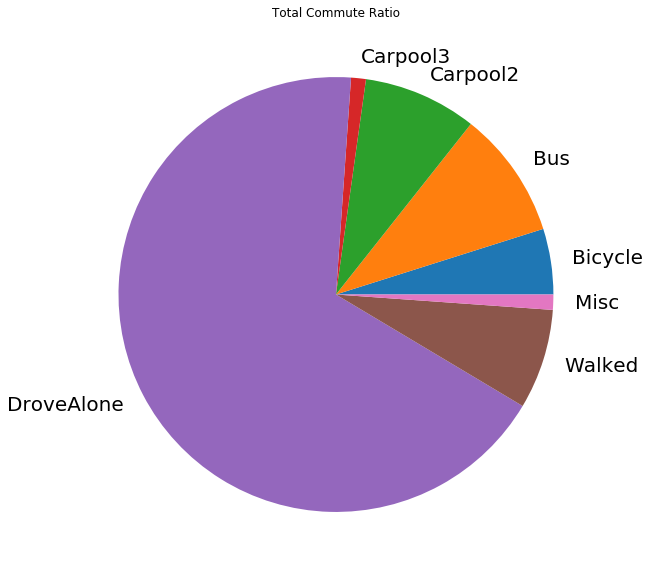

In [63]:
fig, ax = subplots()

circleplot=circledata.plot.pie(figsize=(10,10),title="Total Commute Ratio", ax=ax, fontsize=20) 

circleplot.set_ylabel("")
dataplot3.set_xlabel("")

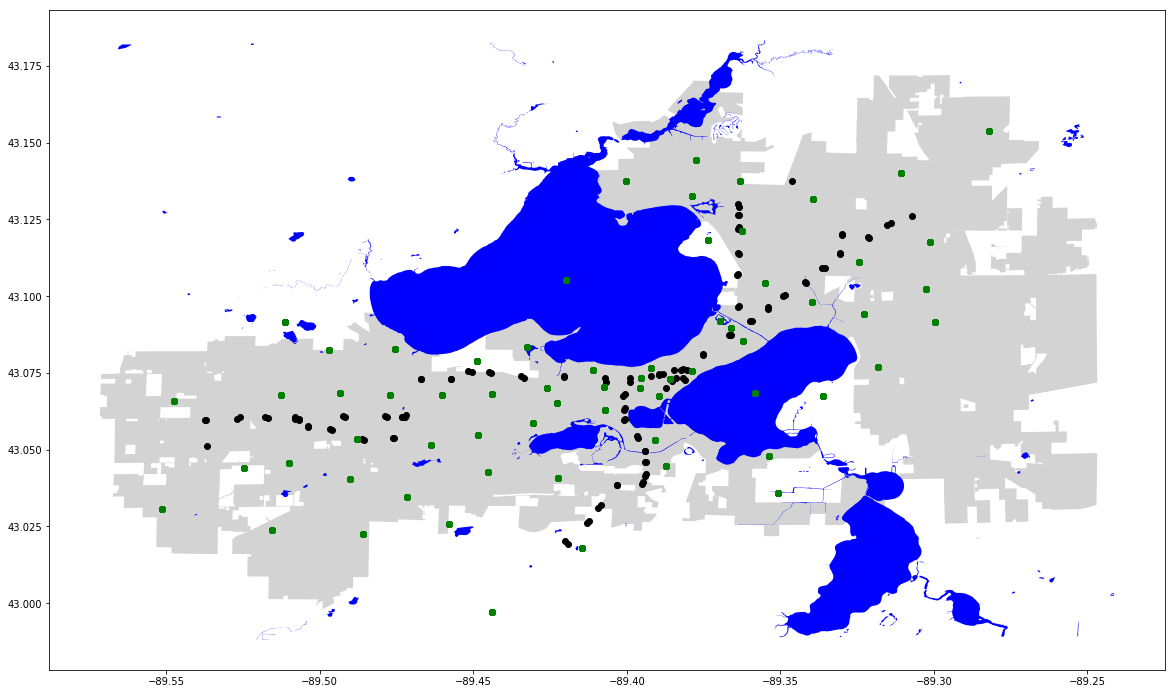

In [64]:
#annotate commute data  
homedic = []
for coor in data3["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)


In [65]:
data2.sort_values(by="Bus", ascending=False)
data2 = copy.deepcopy(data2)
data2.drop('DES_ID', axis=1, inplace=True)
data2.drop('DES_ID_1', axis=1, inplace=True)
data2.drop('DES_LENGTH', axis=1, inplace=True)
data2.drop('OBJECTID_1', axis=1, inplace=True)
data2.drop('OBJECTID', axis=1, inplace=True)
data2.drop('ORG_DES_ID', axis=1, inplace=True)
data2.drop('ORG_DES_ID_1', axis=1, inplace=True)
data2.drop('ORG_ID', axis=1, inplace=True)
data2.drop('ORG_ID_1', axis=1, inplace=True)
data2.drop('RESIDENCE', axis=1, inplace=True)
data2.drop('ShapeSTLength', axis=1, inplace=True)
data2.drop('WORKPLACE', axis=1, inplace=True)
data2.drop('coordinates', axis=1, inplace=True)
data2=data2.sum()
print(data2)
#fig, ax = subplots()
#dataplot2=data2.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
#dataplot2
#ax.annotate('',(70, 13))
#ax.annotate('',(70, 15))
#dataplot2.set_xlabel("Number of commuters")

Bicycle         5640.0
Bus            11090.0
Carpool2        9894.0
Carpool3        1293.0
Carpool4         314.0
Carpool5          89.0
Carpool7         115.0
DroveAlone     79105.0
Ferry             15.0
Motorcycle       350.0
Other            246.0
Rail               0.0
Subway            25.0
Taxi              84.0
Total         116800.0
Trolley           10.0
Walked          8447.0
WorkedHome         0.0
dtype: float64


In [66]:
data3.sort_values(by="Bus", ascending=False)
data3 = copy.deepcopy(data3)
data3.drop('DES_ID', axis=1, inplace=True)
data3.drop('DES_ID_1', axis=1, inplace=True)
data3.drop('DES_LENGTH', axis=1, inplace=True)
data3.drop('OBJECTID_1', axis=1, inplace=True)
data3.drop('OBJECTID', axis=1, inplace=True)
data3.drop('ORG_DES_ID', axis=1, inplace=True)
data3.drop('ORG_DES_ID_1', axis=1, inplace=True)
data3.drop('ORG_ID', axis=1, inplace=True)
data3.drop('ORG_ID_1', axis=1, inplace=True)
data3.drop('RESIDENCE', axis=1, inplace=True)
data3.drop('ShapeSTLength', axis=1, inplace=True)
data3.drop('WORKPLACE', axis=1, inplace=True)
data3.drop('coordinates', axis=1, inplace=True)
data3=data3.sum()
print(data3)
#fig, ax = subplots()
#dataplot3=data3.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
#dataplot3
#ax.annotate('',(70, 13))
#ax.annotate('',(70, 15))
#dataplot3.set_xlabel("Number of commuters")

Bicycle         4232.0
Bus            10046.0
Carpool2        9474.0
Carpool3        1250.0
Carpool4         304.0
Carpool5          39.0
Carpool7         115.0
DroveAlone     76129.0
Ferry             15.0
Motorcycle       320.0
Other            246.0
Rail               0.0
Subway            25.0
Taxi              84.0
Total         105639.0
Trolley           10.0
Walked          3243.0
WorkedHome         0.0
dtype: float64


In [67]:
data4.sort_values(by="Bus", ascending=False)
data4 = copy.deepcopy(data4)
datafour = copy.deepcopy(data4)
data4.drop('DES_ID', axis=1, inplace=True)
data4.drop('DES_ID_1', axis=1, inplace=True)
data4.drop('DES_LENGTH', axis=1, inplace=True)
data4.drop('OBJECTID_1', axis=1, inplace=True)
data4.drop('OBJECTID', axis=1, inplace=True)
data4.drop('ORG_DES_ID', axis=1, inplace=True)
data4.drop('ORG_DES_ID_1', axis=1, inplace=True)
data4.drop('ORG_ID', axis=1, inplace=True)
data4.drop('ORG_ID_1', axis=1, inplace=True)
data4.drop('RESIDENCE', axis=1, inplace=True)
data4.drop('ShapeSTLength', axis=1, inplace=True)
data4.drop('WORKPLACE', axis=1, inplace=True)
data4.drop('coordinates', axis=1, inplace=True)
data4=data4.sum()
print(data4)
#fig, ax = subplots()
#dataplot4=data4.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
#dataplot4
#ax.annotate('',(70, 13))
#ax.annotate('',(70, 15))
#dataplot4.set_xlabel("Number of commuters")

Bicycle        2766.0
Bus            7578.0
Carpool2       8483.0
Carpool3       1127.0
Carpool4        300.0
Carpool5         24.0
Carpool7        100.0
DroveAlone    67722.0
Ferry            15.0
Motorcycle      256.0
Other           246.0
Rail              0.0
Subway           25.0
Taxi             84.0
Total         90467.0
Trolley          10.0
Walked         1606.0
WorkedHome        0.0
dtype: float64


In [68]:
#number of commute comparrason long
stack=pd.concat([fourmile1, data2, data3, data4],axis=1, join_axes=[fourmile1.index])
stack=pd.DataFrame(stack)

#stack.columns = ['Total', '10 min', '30 min', "60 min"]
#stack=stack.transpose()
#stack.drop('Total', axis=1, inplace=True)
#stackfull = copy.deepcopy(stack)
stack

0         1         2        3
Bicycle       5725.0    5640.0    4232.0   2766.0
Bus          11105.0   11090.0   10046.0   7578.0
Carpool2      9909.0    9894.0    9474.0   8483.0
Carpool3      1293.0    1293.0    1250.0   1127.0
Carpool4       314.0     314.0     304.0    300.0
Carpool5        89.0      89.0      39.0     24.0
Carpool7       115.0     115.0     115.0    100.0
DroveAlone   79235.0   79105.0   76129.0  67722.0
Ferry           15.0      15.0      15.0     15.0
Motorcycle     350.0     350.0     320.0    256.0
Other          246.0     246.0     246.0    246.0
Rail             0.0       0.0       0.0      0.0
Subway          25.0      25.0      25.0     25.0
Taxi            84.0      84.0      84.0     84.0
Total       117320.0  116800.0  105639.0  90467.0
Trolley         10.0      10.0      10.0     10.0
Walked        8727.0    8447.0    3243.0   1606.0
WorkedHome       0.0       0.0       0.0      0.0

Text(0.5, 0, 'Number of commuters')

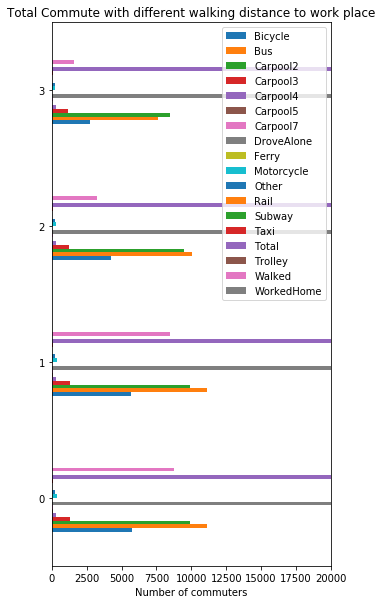

In [69]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Total Commute with different walking distance to work place",xlim=(0,20000), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [70]:
#number of commute comparrason short
stack=pd.concat([fourmile1, data2, data3, data4],axis=1, join_axes=[fourmile1.index])
stack=pd.DataFrame(stack)
stack.columns = ['Total', '10 min', '30 min', "60 min"]
stack=stack.transpose()
stack.drop('WorkedHome', axis=1, inplace=True)
stack.drop('Trolley', axis=1, inplace=True)
stack.drop('Taxi', axis=1, inplace=True)
stack.drop('Subway', axis=1, inplace=True)
stack.drop('Total', axis=1, inplace=True)
stack.drop('Rail', axis=1, inplace=True)
stack.drop('Other', axis=1, inplace=True)
stack.drop('Motorcycle', axis=1, inplace=True)
stack.drop('Ferry', axis=1, inplace=True)
stack.drop('Carpool7', axis=1, inplace=True)
stack.drop('Carpool5', axis=1, inplace=True)
stack.drop('Carpool4', axis=1, inplace=True)
stack=stack/1000

Text(0.5, 0, 'Number of commuters in thousands')

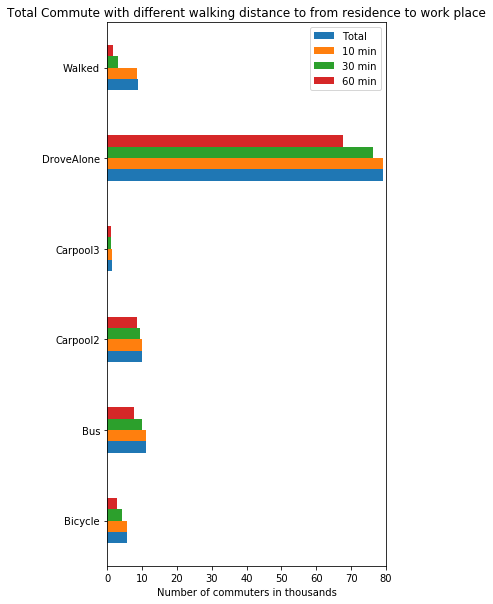

In [71]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Total Commute with different walking distance to from residence to work place",xlim=(0,80), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters in thousands")

In [72]:
#percentage of commute 
data1=fourmile1/fourmile1["Total"]
data2=data2/data2["Total"]
data3=data3/data3["Total"]
data4=data4/data4["Total"]
stack=pd.concat([data1, data2, data3, data4],axis=1, join_axes=[data1.index])
stack=pd.DataFrame(stack)
stack.columns = ['Total', '10 min', '30 min', "60 min"]
stack=stack.transpose()

stack.drop('Total', axis=1, inplace=True)
stackfullper = copy.deepcopy(stack)
stack

Bicycle       Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
Total   0.048798  0.094656  0.084461  0.011021  0.002676  0.000759  0.000980   
10 min  0.048288  0.094949  0.084709  0.011070  0.002688  0.000762  0.000985   
30 min  0.040061  0.095097  0.089683  0.011833  0.002878  0.000369  0.001089   
60 min  0.030575  0.083765  0.093769  0.012458  0.003316  0.000265  0.001105   

        DroveAlone     Ferry  Motorcycle     Other  Rail    Subway      Taxi  \
Total     0.675375  0.000128    0.002983  0.002097   0.0  0.000213  0.000716   
10 min    0.677269  0.000128    0.002997  0.002106   0.0  0.000214  0.000719   
30 min    0.720652  0.000142    0.003029  0.002329   0.0  0.000237  0.000795   
60 min    0.748582  0.000166    0.002830  0.002719   0.0  0.000276  0.000929   

         Trolley    Walked  WorkedHome  
Total   0.000085  0.074386         0.0  
10 min  0.000086  0.072320         0.0  
30 min  0.000095  0.030699         0.0  
60 min  0.000111  0.017752         0.0

Text(0.5, 0, 'Number of commuters')

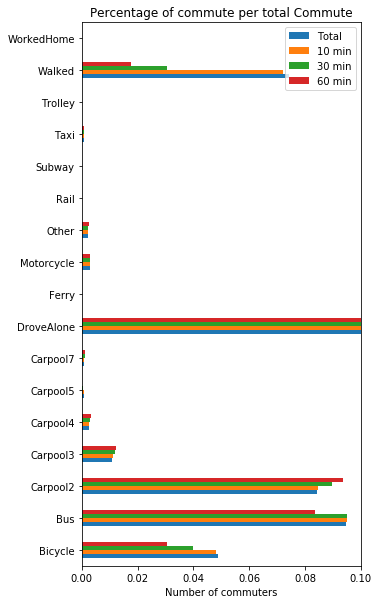

In [73]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Percentage of commute per total Commute",xlim=(0,0.1), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [74]:
stack.drop('Rail', axis=1, inplace=True)
stack.drop('Other', axis=1, inplace=True)
stack.drop('Motorcycle', axis=1, inplace=True)
stack.drop('Ferry', axis=1, inplace=True)
stack.drop('Carpool7', axis=1, inplace=True)
stack.drop('Carpool5', axis=1, inplace=True)
stack.drop('Carpool4', axis=1, inplace=True)
stack.drop('WorkedHome', axis=1, inplace=True)
stack.drop('Trolley', axis=1, inplace=True)
stack.drop('Taxi', axis=1, inplace=True)
stack.drop('Subway', axis=1, inplace=True)

Text(0.5, 0, 'Number of commuters')

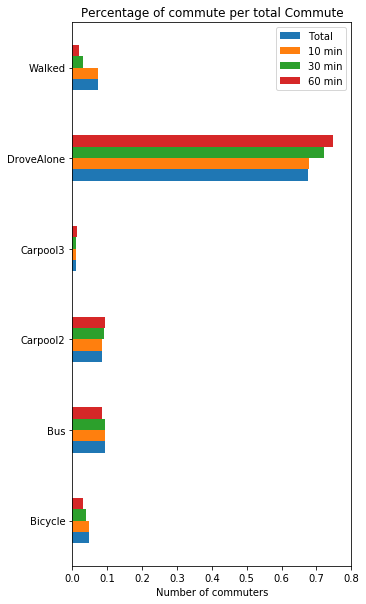

In [75]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Percentage of commute per total Commute",xlim=(0,0.8), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [76]:
misc=-(stack.transpose().sum()-1)
stack=pd.concat([stack, misc],axis=1, join_axes=[stack.index])

In [77]:
stack = stack.rename(columns={0: 'Misc'})
stack

Bicycle       Bus  Carpool2  Carpool3  DroveAlone    Walked      Misc
Total   0.048798  0.094656  0.084461  0.011021    0.675375  0.074386  0.011302
10 min  0.048288  0.094949  0.084709  0.011070    0.677269  0.072320  0.011396
30 min  0.040061  0.095097  0.089683  0.011833    0.720652  0.030699  0.011975
60 min  0.030575  0.083765  0.093769  0.012458    0.748582  0.017752  0.013099

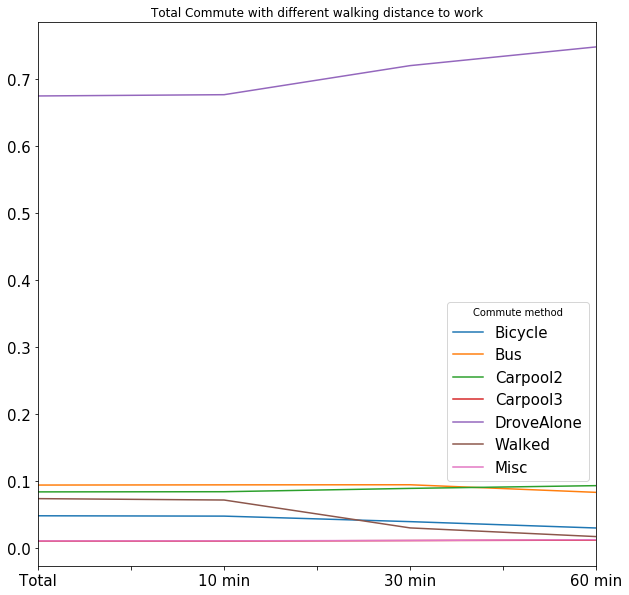

In [78]:
fig, ax = subplots()
stackplot=stack.plot(figsize=(10,10), title="Total Commute with different walking distance to work", fontsize=15, ax=ax)
stackplot.legend(title='Commute method', bbox_to_anchor=(1, 0.5), fontsize = 15)

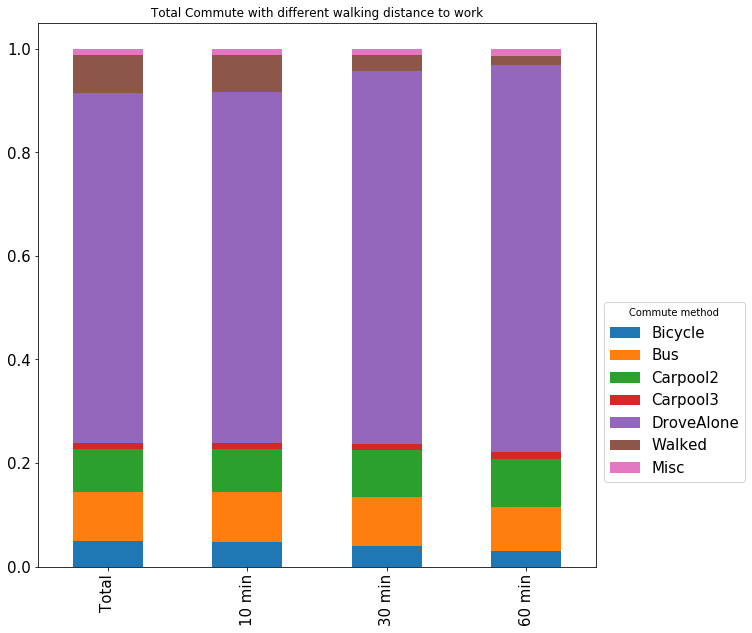

In [79]:
fig, ax = subplots()
stackplot=stack.transpose().T.plot.bar(figsize=(10,10),xlim=(0,1.0), stacked= True, title="Total Commute with different walking distance to work", fontsize=15, ax=ax)
stackplot.legend(title='Commute method', bbox_to_anchor=(1, 0.5), fontsize = 15)


In [80]:
#work and home 10min away and are 10 min from the bus stop
stack10min

Bicycle     Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
None     2499.0  2872.0     852.0      94.0      34.0      40.0      15.0   
10 min   2414.0  2857.0     837.0      94.0      34.0      40.0      15.0   
20 min   2029.0  2642.0     818.0      94.0      34.0      40.0      15.0   
30 min   1339.0  1983.0     698.0      94.0      34.0       0.0      15.0   

        DroveAlone  Ferry  Motorcycle  Other  Rail  Subway  Taxi  Trolley  \
None        6469.0   15.0        58.0   69.0   0.0     0.0  40.0      0.0   
10 min      6339.0   15.0        58.0   69.0   0.0     0.0  40.0      0.0   
20 min      6174.0   15.0        58.0   69.0   0.0     0.0  40.0      0.0   
30 min      5525.0   15.0        43.0   69.0   0.0     0.0  40.0      0.0   

        Walked  WorkedHome  
None    6229.0         0.0  
10 min  5949.0         0.0  
20 min  4019.0         0.0  
30 min  1299.0         0.0

In [81]:
#ratio of work and home 10 min away and are 10 min from the bus stop
stack10minper

Bicycle       Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
None    0.129623  0.148970  0.044193  0.004876  0.001764  0.002075  0.000778   
10 min  0.128685  0.152300  0.044619  0.005011  0.001812  0.002132  0.000800   
20 min  0.126504  0.164723  0.051001  0.005861  0.002120  0.002494  0.000935   
30 min  0.119939  0.177625  0.062522  0.008420  0.003046  0.000000  0.001344   

        DroveAlone     Ferry  Motorcycle     Other  Rail  Subway      Taxi  \
None      0.335546  0.000778    0.003008  0.003579   0.0     0.0  0.002075   
10 min    0.337918  0.000800    0.003092  0.003678   0.0     0.0  0.002132   
20 min    0.384937  0.000935    0.003616  0.004302   0.0     0.0  0.002494   
30 min    0.494894  0.001344    0.003852  0.006181   0.0     0.0  0.003583   

        Trolley    Walked  WorkedHome  
None        0.0  0.323098         0.0  
10 min      0.0  0.317128         0.0  
20 min      0.0  0.250577         0.0  
30 min      0.0  0.116356         0.0

In [82]:
#fullwpdata ratio
stackfullper

Bicycle       Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
Total   0.048798  0.094656  0.084461  0.011021  0.002676  0.000759  0.000980   
10 min  0.048288  0.094949  0.084709  0.011070  0.002688  0.000762  0.000985   
30 min  0.040061  0.095097  0.089683  0.011833  0.002878  0.000369  0.001089   
60 min  0.030575  0.083765  0.093769  0.012458  0.003316  0.000265  0.001105   

        DroveAlone     Ferry  Motorcycle     Other  Rail    Subway      Taxi  \
Total     0.675375  0.000128    0.002983  0.002097   0.0  0.000213  0.000716   
10 min    0.677269  0.000128    0.002997  0.002106   0.0  0.000214  0.000719   
30 min    0.720652  0.000142    0.003029  0.002329   0.0  0.000237  0.000795   
60 min    0.748582  0.000166    0.002830  0.002719   0.0  0.000276  0.000929   

         Trolley    Walked  WorkedHome  
Total   0.000085  0.074386         0.0  
10 min  0.000086  0.072320         0.0  
30 min  0.000095  0.030699         0.0  
60 min  0.000111  0.017752         0.0

In [83]:
#data for commute from fitchburg
dic = []
for index in data["OBJECTID"]:
    coordinatess = data[data["OBJECTID"] == index]
    coordinates = coordinatess["coordinates"]
    for coor in coordinates:
        home = [coor[0], coor[1]]
        if home == ["-89.41467673587252", "43.017885822944216"]:
            dic.append(coordinatess)
            
datassss=pd.concat(dic)

    

In [84]:
datassss.sort_values(by="Bus", ascending=False)
fitch = copy.deepcopy(datassss)
fitch.drop('DES_ID', axis=1, inplace=True)
fitch.drop('DES_ID_1', axis=1, inplace=True)
fitch.drop('DES_LENGTH', axis=1, inplace=True)
fitch.drop('OBJECTID_1', axis=1, inplace=True)
fitch.drop('OBJECTID', axis=1, inplace=True)
fitch.drop('ORG_DES_ID', axis=1, inplace=True)
fitch.drop('ORG_DES_ID_1', axis=1, inplace=True)
fitch.drop('ORG_ID', axis=1, inplace=True)
fitch.drop('ORG_ID_1', axis=1, inplace=True)
fitch.drop('RESIDENCE', axis=1, inplace=True)
fitch.drop('ShapeSTLength', axis=1, inplace=True)
fitch.drop('WORKPLACE', axis=1, inplace=True)
fitch.drop('coordinates', axis=1, inplace=True)
fitch=fitch.sum()
fitch

Bicycle         40.0
Bus             55.0
Carpool2       215.0
Carpool3        15.0
Carpool4         0.0
Carpool5         0.0
Carpool7         0.0
DroveAlone    1145.0
Ferry           15.0
Motorcycle       0.0
Other           10.0
Rail             0.0
Subway           0.0
Taxi             0.0
Total         1490.0
Trolley          0.0
Walked           0.0
WorkedHome       0.0
dtype: float64

In [85]:
#data for most north 
dic = []
for index in data["OBJECTID"]:
    coordinatess = data[data["OBJECTID"] == index]
    coordinates = coordinatess["coordinates"]
    for coor in coordinates:
        home = [coor[0], coor[1]]
        if home == ["-89.36236944652443","43.121105967515604"]:
            dic.append(coordinatess)
            
datassss=pd.concat(dic)


In [86]:
datassss.sort_values(by="Bus", ascending=False)
north = copy.deepcopy(datassss)
north.drop('DES_ID', axis=1, inplace=True)
north.drop('DES_ID_1', axis=1, inplace=True)
north.drop('DES_LENGTH', axis=1, inplace=True)
north.drop('OBJECTID_1', axis=1, inplace=True)
north.drop('OBJECTID', axis=1, inplace=True)
north.drop('ORG_DES_ID', axis=1, inplace=True)
north.drop('ORG_DES_ID_1', axis=1, inplace=True)
north.drop('ORG_ID', axis=1, inplace=True)
north.drop('ORG_ID_1', axis=1, inplace=True)
north.drop('RESIDENCE', axis=1, inplace=True)
north.drop('ShapeSTLength', axis=1, inplace=True)
north.drop('WORKPLACE', axis=1, inplace=True)
north.drop('coordinates', axis=1, inplace=True)
north=north.sum()
north

Bicycle        15.0
Bus            60.0
Carpool2       45.0
Carpool3       30.0
Carpool4        0.0
Carpool5        0.0
Carpool7        0.0
DroveAlone    580.0
Ferry           0.0
Motorcycle      0.0
Other           0.0
Rail            0.0
Subway          0.0
Taxi            0.0
Total         725.0
Trolley         0.0
Walked          0.0
WorkedHome      0.0
dtype: float64

In [87]:
#data for most west 
dic = []
for index in data["OBJECTID"]:
    coordinatess = data[data["OBJECTID"] == index]
    coordinates = coordinatess["coordinates"]
    for coor in coordinates:
        home = [coor[0], coor[1]]
        if home == ["-89.48804385843933", "43.053604975746346"]:
            dic.append(coordinatess)
            
datassss=pd.concat(dic)


In [88]:
datassss.sort_values(by="Bus", ascending=False)
west = copy.deepcopy(datassss)
west.drop('DES_ID', axis=1, inplace=True)
west.drop('DES_ID_1', axis=1, inplace=True)
west.drop('DES_LENGTH', axis=1, inplace=True)
west.drop('OBJECTID_1', axis=1, inplace=True)
west.drop('OBJECTID', axis=1, inplace=True)
west.drop('ORG_DES_ID', axis=1, inplace=True)
west.drop('ORG_DES_ID_1', axis=1, inplace=True)
west.drop('ORG_ID', axis=1, inplace=True)
west.drop('ORG_ID_1', axis=1, inplace=True)
west.drop('RESIDENCE', axis=1, inplace=True)
west.drop('ShapeSTLength', axis=1, inplace=True)
west.drop('WORKPLACE', axis=1, inplace=True)
west.drop('coordinates', axis=1, inplace=True)
west=west.sum()
west

Bicycle        10.0
Bus            40.0
Carpool2        0.0
Carpool3        0.0
Carpool4        0.0
Carpool5        0.0
Carpool7        0.0
DroveAlone     84.0
Ferry           0.0
Motorcycle      0.0
Other           0.0
Rail            0.0
Subway          0.0
Taxi            0.0
Total         134.0
Trolley         0.0
Walked          0.0
WorkedHome      0.0
dtype: float64

In [89]:
#data for most east 
dic = []
for index in data["OBJECTID"]:
    coordinatess = data[data["OBJECTID"] == index]
    coordinates = coordinatess["coordinates"]
    for coor in coordinates:
        home = [coor[0], coor[1]]
        if home == ["-89.32437481157999", "43.111270326144165"]:
            dic.append(coordinatess)
            
datassss=pd.concat(dic)


In [90]:
datassss.sort_values(by="Bus", ascending=False)
east = copy.deepcopy(datassss)
east.drop('DES_ID', axis=1, inplace=True)
east.drop('DES_ID_1', axis=1, inplace=True)
east.drop('DES_LENGTH', axis=1, inplace=True)
east.drop('OBJECTID_1', axis=1, inplace=True)
east.drop('OBJECTID', axis=1, inplace=True)
east.drop('ORG_DES_ID', axis=1, inplace=True)
east.drop('ORG_DES_ID_1', axis=1, inplace=True)
east.drop('ORG_ID', axis=1, inplace=True)
east.drop('ORG_ID_1', axis=1, inplace=True)
east.drop('RESIDENCE', axis=1, inplace=True)
east.drop('ShapeSTLength', axis=1, inplace=True)
east.drop('WORKPLACE', axis=1, inplace=True)
east.drop('coordinates', axis=1, inplace=True)
east=east.sum()
east

Bicycle         0.0
Bus            10.0
Carpool2       50.0
Carpool3        0.0
Carpool4        0.0
Carpool5        0.0
Carpool7        0.0
DroveAlone    172.0
Ferry           0.0
Motorcycle      0.0
Other           0.0
Rail            0.0
Subway          0.0
Taxi            0.0
Total         232.0
Trolley         0.0
Walked          0.0
WorkedHome      0.0
dtype: float64

In [91]:
#stacked data of all the 4 picked high density commute
stackofmost=pd.concat([east, west, north, fitch],axis=1, join_axes=[east.index])
stackofmost=pd.DataFrame(stackofmost)
stackofmost.columns = ['east', 'west', 'north', "fitch"]
stackofmost=stackofmost.transpose()
stackofmost

Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
east       0.0  10.0      50.0       0.0       0.0       0.0       0.0   
west      10.0  40.0       0.0       0.0       0.0       0.0       0.0   
north     15.0  60.0      45.0      30.0       0.0       0.0       0.0   
fitch     40.0  55.0     215.0      15.0       0.0       0.0       0.0   

       DroveAlone  Ferry  Motorcycle  Other  Rail  Subway  Taxi   Total  \
east        172.0    0.0         0.0    0.0   0.0     0.0   0.0   232.0   
west         84.0    0.0         0.0    0.0   0.0     0.0   0.0   134.0   
north       580.0    0.0         0.0    0.0   0.0     0.0   0.0   725.0   
fitch      1145.0   15.0         0.0   10.0   0.0     0.0   0.0  1490.0   

       Trolley  Walked  WorkedHome  
east       0.0     0.0         0.0  
west       0.0     0.0         0.0  
north      0.0     0.0         0.0  
fitch      0.0     0.0         0.0

Text(0.5, 0, 'Number of commuters')

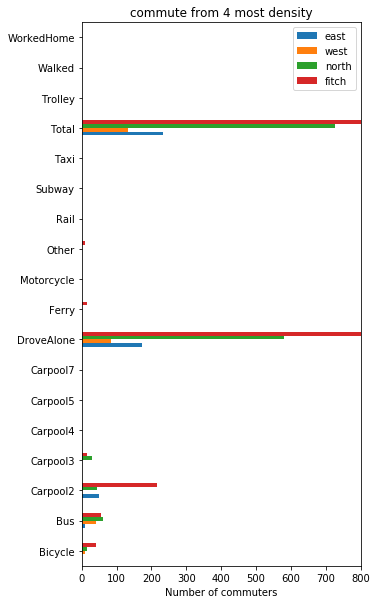

In [92]:
fig, ax = subplots()

stackofmostplot=stackofmost.T.plot.barh(figsize=(5,10),title="commute from 4 most density",xlim=(0,800), ax=ax) 
stackofmostplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackofmostplot.set_xlabel("Number of commuters")

In [93]:
stackofmost.drop('Rail', axis=1, inplace=True)
stackofmost.drop('Other', axis=1, inplace=True)
stackofmost.drop('Motorcycle', axis=1, inplace=True)
stackofmost.drop('Ferry', axis=1, inplace=True)
stackofmost.drop('Carpool7', axis=1, inplace=True)
stackofmost.drop('Carpool5', axis=1, inplace=True)
stackofmost.drop('Carpool4', axis=1, inplace=True)
stackofmost.drop('WorkedHome', axis=1, inplace=True)
stackofmost.drop('Trolley', axis=1, inplace=True)
stackofmost.drop('Taxi', axis=1, inplace=True)
stackofmost.drop('Subway', axis=1, inplace=True)
stackofmost.drop("Walked", axis=1, inplace=True)
stackofmost.drop("Total", axis=1, inplace=True)

Text(0.5, 0, 'Number of commuters')

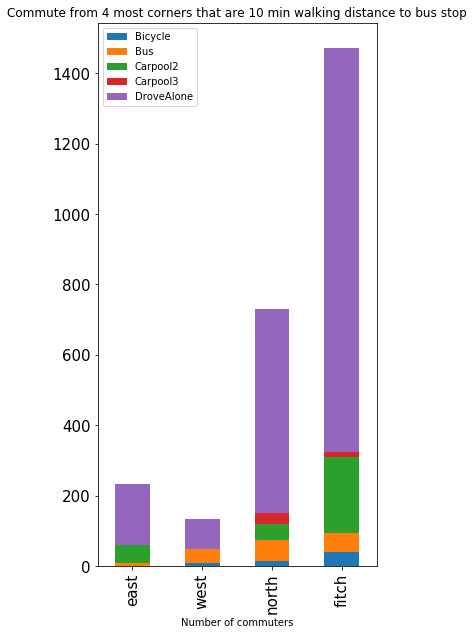

In [211]:
fig, ax = subplots()

stackofmostplot=stackofmost.transpose().T.plot.bar(figsize=(5,10),stacked = True,title="Commute from 4 most corners that are 10 min walking distance to bus stop",xlim=(0,1500),fontsize = 15, ax=ax) 
stackofmostplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackofmostplot.set_xlabel("Number of commuters")

In [123]:
#choosing locations that are within the madison map from the wpdata regardless of what the distance is from the bus stops
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
    
for index in wpdata["OBJECTID"]:
    coordinates = wpdata[wpdata["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for coor in coordinates:                    
        lat1 = float(coor[1])
        lon1 = float(coor[0])
        lat2 = float(coor[3])
        lon2 = float(coor[2])
        if 42.975 < lat1 < 43.2:
            if -89.6 <lon1 < -89.20:
                if 42.975 < lat2 < 43.2:
                    if -89.6 < lon2 < -89.20:
                        dic.append(wpdata[wpdata["OBJECTID"]==index])
                       
madisondata=pd.concat(dic)
madisondata.head()                    
                        


Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                    
1             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
2             0.0  25.0       0.0       0.0       0.0       0.0       0.0   
3             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
4             0.0   0.0       0.0       0.0       0.0       0.0       0.0   
5             0.0   0.0       0.0       0.0       0.0       0.0       0.0   

          DES_ID  DES_ID_1    DES_LENGTH  ...  Rail  ShapeSTLength  Subway  \
OBJECTID                                  ...                                
1           10.0      10.0  14888.338340  ...   0.0   14888.338340     0.0   
2          101.0     101.0   7271.941348  ...   0.0    7271.941348     0.0   
3          102.0     102.0  30090.845436  ...   0.0   30090.845436     0.0   
4          103.0     103.0  37615.520001  ...   0.0   37615.520001     0.0   
5          104.0     104.0  39009.663787  ...   0.0   39009.663787     0.0   

          Taxi  Total Trolley                                 WORKPLACE  \
OBJECTID                                                                  
1          0.0   10.0     0.0   Census Tract 10, Dane County, Wisconsin   
2          0.0   35.0     0.0  Census Tract 101, Dane County, Wisconsin   
3          0.0    0.0     0.0  Census Tract 102, Dane County, Wisconsin   
4          0.0    0.0     0.0  Census Tract 103, Dane County, Wisconsin   
5          0.0    0.0     0.0  Census Tract 104, Dane County, Wisconsin   

          Walked  WorkedHome  \
OBJECTID                       
1            0.0         0.0   
2            0.0         0.0   
3            0.0         0.0   
4            0.0         0.0   
5            0.0         0.0   

                                                coordinates  
OBJECTID                                                     
1         [-89.47539185715189, 43.08293455103483, -89.43...  
2         [-89.47539185715189, 43.08293455103483, -89.44...  
3         [-89.47539185715189, 43.08293455103483, -89.37...  
4         [-89.47539185715189, 43.08293455103483, -89.33...  
5         [-89.47539185715189, 43.08293455103483, -89.33...  

[5 rows x 31 columns]

In [181]:
#choosing madisondata to only close to bus stops
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
for index in madisondata["OBJECTID"]:
    coordinates = madisondata[madisondata["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for bcoor in rbusdata["coordinates"]:
        for coor in coordinates:                    
            lat1 = radians(float(coor[1]))
            lon1 = radians(float(coor[0]))
            lat2 = radians(float(bcoor[1]))
            lon2 = radians(float(bcoor[0]))
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            if distance <= 4:
                for bcoorr in rbusdata["coordinates"]:
                    lat1 = radians(float(coor[3]))
                    lon1 = radians(float(coor[2]))
                    lat2 = radians(float(bcoorr[1]))
                    lon2 = radians(float(bcoorr[0]))
                    dlon = lon2 - lon1
                    dlat = lat2 - lat1
                    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                    c = 2 * atan2(sqrt(a), sqrt(1 - a))
                    distance = R * c
                    if distance <= 0.6:
                        dic.append(madisondata[madisondata["OBJECTID"]==index])
shortmadison=pd.concat(dic)  
ssmadison = copy.deepcopy(shortmadison)
ssmadison=ssmadison.drop_duplicates(subset=["OBJECTID"], keep="first")
ssmadison

Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                    
2             0.0  25.0       0.0       0.0       0.0       0.0       0.0   
15           30.0  25.0       4.0       0.0       0.0       0.0       0.0   
16            0.0  55.0       0.0       4.0       0.0       0.0       0.0   
33            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
47            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
54            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
56            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
59            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
60            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
61            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
62            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
63            0.0  30.0       0.0       0.0       0.0       0.0       0.0   
64            0.0  10.0      10.0       0.0       0.0       0.0       0.0   
65            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
66            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
67            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
74            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
80            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
96            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
104           0.0   0.0      10.0       0.0       0.0       0.0       0.0   
108           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
121           0.0  45.0       0.0       0.0       0.0       0.0       0.0   
122          75.0  80.0      15.0       0.0       0.0       0.0       0.0   
139           0.0  10.0       0.0       0.0       0.0       0.0       0.0   
153           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
160           0.0  20.0       0.0       0.0       0.0       0.0       0.0   
162           0.0   0.0      35.0       0.0       0.0       0.0       0.0   
165           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
166           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
167           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
...           ...   ...       ...       ...       ...       ...       ...   
11193         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11194         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11195         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11196         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11197         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11198         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11205         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11211         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11227         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11235         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11239         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11252         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11253         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11270         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11284         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11291         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11293         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11296         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11297         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11298 

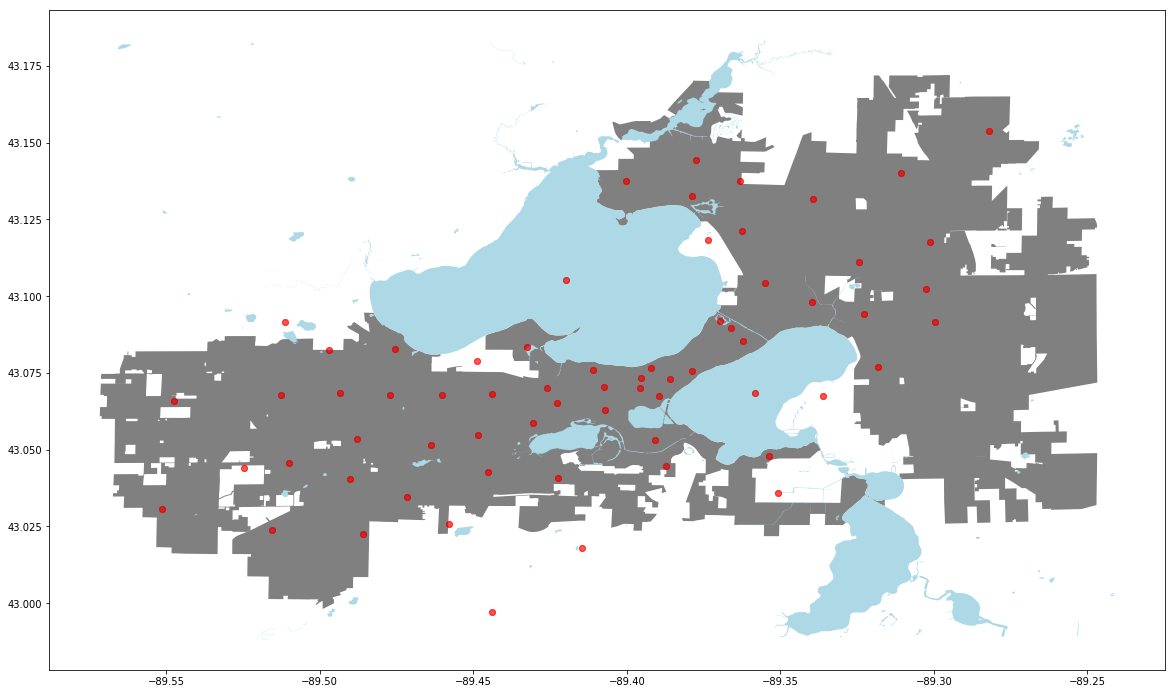

In [182]:
homedic = []
for coor in ssmadison["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
hs.plot(color="red", ax=ax, alpha=0.05)

In [183]:
#choosing locations that are 10 min away from bus stop from madison sample
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
#sampledata = madisondata.sample(n=800)    
for index in ssmadison["OBJECTID"]:
    coordinates = ssmadison[ssmadison["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for bcoor in rbusdata["coordinates"]:
        for coor in coordinates:                    
            lat1 = radians(float(coor[1]))
            lon1 = radians(float(coor[0]))
            lat2 = radians(float(bcoor[1]))
            lon2 = radians(float(bcoor[0]))
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            if distance <= 0.6:
                for bcoorr in rbusdata["coordinates"]:
                    lat1 = radians(float(coor[3]))
                    lon1 = radians(float(coor[2]))
                    lat2 = radians(float(bcoorr[1]))
                    lon2 = radians(float(bcoorr[0]))
                    dlon = lon2 - lon1
                    dlat = lat2 - lat1
                    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                    c = 2 * atan2(sqrt(a), sqrt(1 - a))
                    distance = R * c
                    if distance <= 0.6:
                        dic.append(ssmadison[ssmadison["OBJECTID"]==index])

In [184]:
sdata=pd.concat(dic)  
ssdata = copy.deepcopy(sdata)
ssdata=ssdata.drop_duplicates(subset=["OBJECTID"], keep="first")
ssdata

Bicycle    Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                     
227           4.0    4.0      10.0       0.0       0.0       0.0       0.0   
228          30.0   10.0       4.0       4.0       0.0       0.0       0.0   
245           4.0    0.0       4.0       0.0       0.0       0.0       0.0   
259           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
266           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
268           4.0    0.0       0.0       0.0       0.0       0.0       0.0   
271           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
272           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
273           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
274           4.0    0.0       0.0       0.0       0.0       0.0       0.0   
275           4.0    0.0       0.0       0.0       0.0       0.0       0.0   
276           4.0    4.0       0.0       0.0       0.0       0.0       0.0   
277           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
278           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
279           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
286           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
292           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
308           0.0    0.0       0.0       0.0       0.0       0.0       0.0   
316           0.0    0.0       0.0       0.0       4.0       0.0       0.0   
1593          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1606         95.0    0.0       0.0       0.0       0.0       0.0       0.0   
1623          0.0    0.0      15.0       0.0       0.0       0.0       0.0   
1637          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1644          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1646          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1649         25.0   10.0       0.0       0.0       0.0       0.0       0.0   
1650         40.0    0.0       0.0       0.0       0.0       0.0       0.0   
1651          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1652          0.0    0.0       0.0       0.0       0.0       0.0       0.0   
1653         10.0   10.0       0.0       0.0       0.0       0.0       0.0   
...           ...    ...       ...       ...       ...       ...       ...   
10237         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10238         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10239         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10240         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10241         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10242         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10243         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10244         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10251         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10257         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
10280         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11027        50.0    0.0       0.0       0.0       0.0       0.0       0.0   
11040        40.0   35.0       0.0       0.0       0.0       0.0       0.0   
11041       120.0  145.0      55.0       0.0       0.0       0.0       0.0   
11058         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11072         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11079         0.0    0.0       0.0       0.0       0.0       0.0       0.0   
11081         0.0    0.0      10.0       0.0       0.0       0.0       0.0   
11084         0.0   15.0       0

In [185]:
test = copy.deepcopy(ssmadison)

In [186]:
for counter in test["OBJECTID"]:
    if list(ssdata["OBJECTID"]).count(counter) == 1:
        test = test[test.index != counter]

test

Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                    
2             0.0  25.0       0.0       0.0       0.0       0.0       0.0   
15           30.0  25.0       4.0       0.0       0.0       0.0       0.0   
16            0.0  55.0       0.0       4.0       0.0       0.0       0.0   
33            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
47            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
54            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
56            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
59            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
60            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
61            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
62            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
63            0.0  30.0       0.0       0.0       0.0       0.0       0.0   
64            0.0  10.0      10.0       0.0       0.0       0.0       0.0   
65            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
66            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
67            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
74            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
80            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
96            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
104           0.0   0.0      10.0       0.0       0.0       0.0       0.0   
108           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
121           0.0  45.0       0.0       0.0       0.0       0.0       0.0   
122          75.0  80.0      15.0       0.0       0.0       0.0       0.0   
139           0.0  10.0       0.0       0.0       0.0       0.0       0.0   
153           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
160           0.0  20.0       0.0       0.0       0.0       0.0       0.0   
162           0.0   0.0      35.0       0.0       0.0       0.0       0.0   
165           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
166           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
167           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
...           ...   ...       ...       ...       ...       ...       ...   
11193         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11194         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11195         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11196         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11197         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11198         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11205         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11211         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11227         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11235         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11239         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11252         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11253         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11270         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11284         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11291         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11293         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11296         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11297         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11298 

In [187]:
#choosing locations that are 10 min away from bus stop from madison sample
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
#sampledata = madisondata.sample(n=800)    
for index in test["OBJECTID"]:
    coordinates = test[test["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for bcoor in rbusdata["coordinates"]:
        for coor in coordinates:                    
            lat1 = radians(float(coor[1]))
            lon1 = radians(float(coor[0]))
            lat2 = radians(float(bcoor[1]))
            lon2 = radians(float(bcoor[0]))
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            if distance < 1.8:
                for bcoorr in rbusdata["coordinates"]:
                    lat1 = radians(float(coor[3]))
                    lon1 = radians(float(coor[2]))
                    lat2 = radians(float(bcoorr[1]))
                    lon2 = radians(float(bcoorr[0]))
                    dlon = lon2 - lon1
                    dlat = lat2 - lat1
                    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                    c = 2 * atan2(sqrt(a), sqrt(1 - a))
                    distance = R * c
                    if distance <= 0.6:
                        dic.append(test[test["OBJECTID"]==index])


In [188]:
awaydata=pd.concat(dic)  
adata = copy.deepcopy(awaydata)
adata=adata.drop_duplicates(subset=["OBJECTID"], keep="first")
adata

Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                    
2             0.0  25.0       0.0       0.0       0.0       0.0       0.0   
15           30.0  25.0       4.0       0.0       0.0       0.0       0.0   
16            0.0  55.0       0.0       4.0       0.0       0.0       0.0   
33            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
47            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
54            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
56            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
59            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
60            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
61            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
62            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
63            0.0  30.0       0.0       0.0       0.0       0.0       0.0   
64            0.0  10.0      10.0       0.0       0.0       0.0       0.0   
65            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
66            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
67            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
74            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
80            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
96            0.0   0.0       0.0       0.0       0.0       0.0       0.0   
104           0.0   0.0      10.0       0.0       0.0       0.0       0.0   
108           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
121           0.0  45.0       0.0       0.0       0.0       0.0       0.0   
122          75.0  80.0      15.0       0.0       0.0       0.0       0.0   
139           0.0  10.0       0.0       0.0       0.0       0.0       0.0   
153           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
160           0.0  20.0       0.0       0.0       0.0       0.0       0.0   
162           0.0   0.0      35.0       0.0       0.0       0.0       0.0   
165           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
166           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
167           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
...           ...   ...       ...       ...       ...       ...       ...   
10875         0.0  15.0       0.0       0.0       0.0       0.0       0.0   
10876         0.0  10.0       0.0       0.0       0.0       0.0       0.0   
10877        10.0  45.0       4.0       0.0       0.0       0.0       0.0   
10878         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10879         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10880         0.0   0.0      10.0       0.0       0.0       0.0       0.0   
10887         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10893         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10909        20.0   0.0       0.0       0.0       0.0       0.0       0.0   
10916         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10921        20.0   0.0       0.0       0.0       0.0       0.0       0.0   
10934        30.0  20.0       0.0       0.0       0.0       0.0       0.0   
10935        45.0  20.0      10.0       0.0       0.0       0.0       0.0   
10952         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10966         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10973         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10975         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10978        15.0   0.0       0.0       0.0       0.0       0.0       0.0   
10979         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
10980 

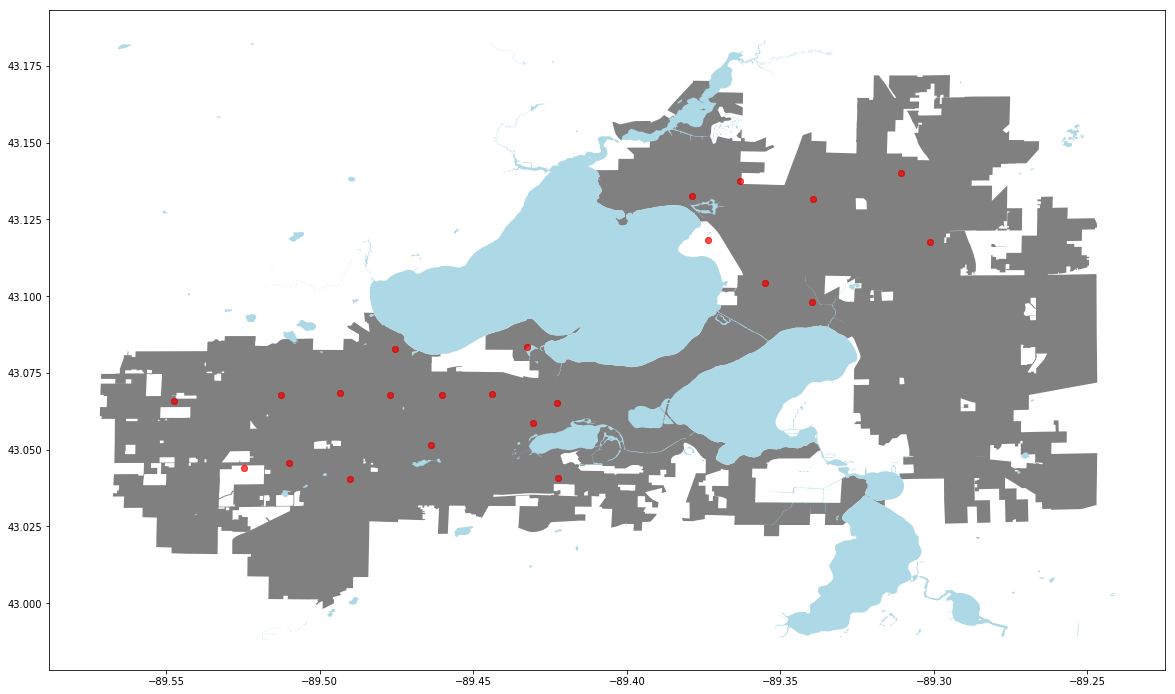

In [189]:
homedic = []
for coor in adata["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
hs.plot(color="red", ax=ax, alpha=0.05)

In [190]:
for counter in test["OBJECTID"]:
    if list(adata["OBJECTID"]).count(counter) == 1:
        test = test[test.index != counter]

test

Bicycle   Bus  Carpool2  Carpool3  Carpool4  Carpool5  Carpool7  \
OBJECTID                                                                    
427          10.0   0.0       0.0       0.0       0.0       0.0       0.0   
439           0.0  15.0      10.0       0.0       0.0       0.0       0.0   
440          50.0   0.0       0.0       0.0       0.0       0.0       0.0   
457           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
471           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
478           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
480          10.0   0.0       0.0       0.0       0.0       0.0       0.0   
483           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
484           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
485           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
486           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
487           0.0  10.0      10.0       0.0       0.0       0.0       0.0   
488           0.0  20.0       0.0       0.0       0.0       0.0       0.0   
489           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
490          10.0   0.0       0.0       0.0       0.0       0.0       0.0   
491           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
498           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
504           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
520          10.0   0.0      10.0       0.0       0.0       0.0       0.0   
528           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
957           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
969           0.0  20.0       0.0       0.0       0.0       0.0       0.0   
970           0.0  15.0      80.0       0.0       0.0       0.0       0.0   
987           0.0   0.0       0.0       0.0       0.0       0.0       0.0   
1001          0.0   0.0       0.0       0.0       0.0       0.0       0.0   
1008          0.0   0.0      20.0       0.0       0.0       0.0       0.0   
1010         20.0   0.0      20.0       0.0       0.0       0.0       0.0   
1013          0.0   0.0       0.0       0.0       0.0       0.0       0.0   
1014          0.0   0.0       0.0       0.0       0.0       0.0       0.0   
1015          0.0   0.0       0.0       0.0       0.0       0.0       0.0   
...           ...   ...       ...       ...       ...       ...       ...   
11193         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11194         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11195         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11196         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11197         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11198         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11205         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11211         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11227         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11235         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11239         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11252         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11253         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11270         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11284         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11291         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11293         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11296         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11297         0.0   0.0       0.0       0.0       0.0       0.0       0.0   
11298 

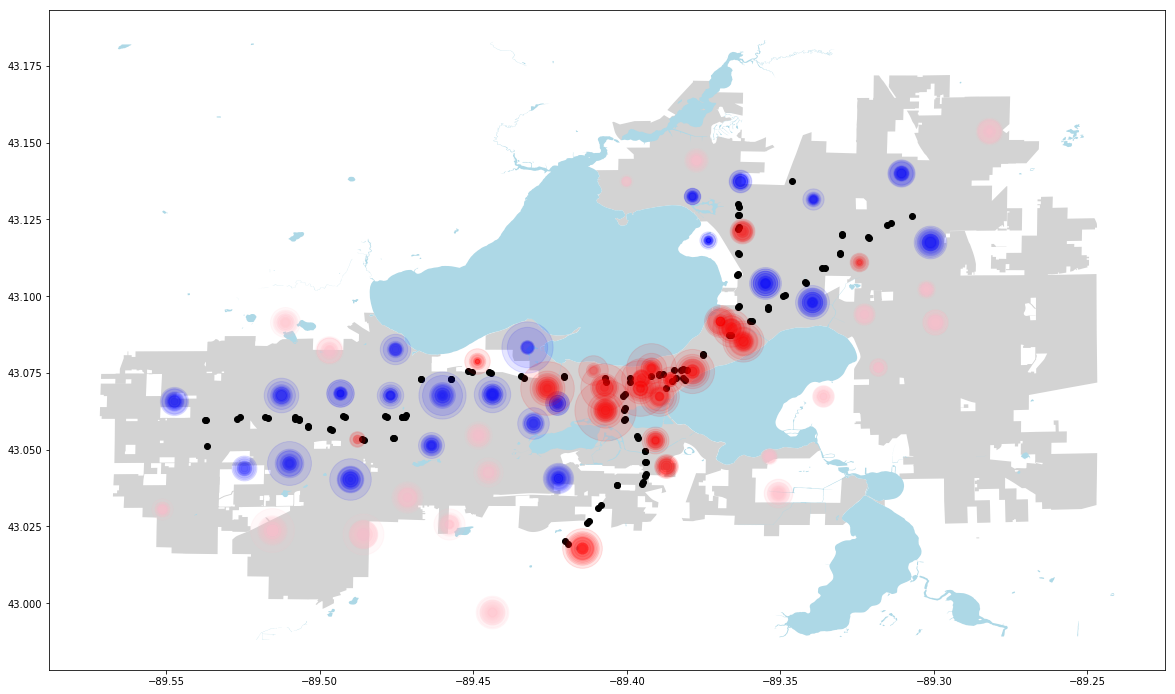

In [191]:
#annotate commute data from the madisondata
#making the dots bigger according to travel size 
#reference_____https://pynative.com/python-generate-random-string/
#reference_____http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
#mport random
#import string

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
data.fillna(0, inplace=True)
dic = range(0, len(fourmile))
dic = list(dic)
i = 0
for index in adata["OBJECTID"]:
    locat = adata[adata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic = []
        homedic.append(Point(float(coor[0]),float(coor[1])))
        hcoords = pd.Series(homedic)
        hs = pd.DataFrame({"Coordinates": hcoords})
        hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
        total = locat["Total"]
        pop=float(total)*5
        dic[i] = hs
        dic[i].plot(color="blue", ax=ax, markersize=pop, alpha=0.1)
        i += 1
for index in test["OBJECTID"]:
    locat = test[test["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic = []
        homedic.append(Point(float(coor[0]),float(coor[1])))
        hcoords = pd.Series(homedic)
        hs = pd.DataFrame({"Coordinates": hcoords})
        hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
        total = locat["Total"]
        pop=float(total)*5
        dic[i] = hs
        dic[i].plot(color="pink", ax=ax, markersize=pop, alpha=0.1)
        i += 1
for index in ssdata["OBJECTID"]:
    locat = ssdata[ssdata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic = []
        homedic.append(Point(float(coor[0]),float(coor[1])))
        hcoords = pd.Series(homedic)
        hs = pd.DataFrame({"Coordinates": hcoords})
        hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
        total = locat["Total"]
        pop=float(total)*5
        dic[i] = hs
        dic[i].plot(color="red", ax=ax, markersize=pop, alpha=0.1)
        i += 1

In [192]:
#sum of the totals with same home coordiantes 
dic =[]
dicc= []
for index in ssdata["OBJECTID"]:
    locat = ssdata[ssdata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        dic.append(float(coor[0]))
        dicc.append(float(coor[1]))
ssdata["coor"] = dic
ssdata["coorr"] = dicc
#test adata ssdata
dictotal =[]
diccoor = [] 
countdic= [] 
dic =[]
for index in ssdata["OBJECTID"]:
    locat = ssdata[ssdata["OBJECTID"]==index]
    for coor in locat["coor"]:
        for coorr in locat["coorr"]:
            countdic.append([coor, coorr])
            if countdic.count([coor, coorr]) ==1:
                samecoor=ssdata[ssdata["coor"]==coor]
                samecoor=samecoor[samecoor["coorr"]==coorr]
                dictotal.append(samecoor['Total'].sum())
                diccoor.append([float(coor), float(coorr)])

dictotal=pd.DataFrame(dictotal)
diccoor=pd.DataFrame(diccoor)
ssdatatotal=pd.concat([dictotal, diccoor],axis=1)
ssdatatotal.columns = ["total","lon","lat"]
ssdatatotal  
    

total        lon        lat
0    314.0 -89.448704  43.079020
1   1220.0 -89.407390  43.070565
2    265.0 -89.411166  43.075791
3   2000.0 -89.406976  43.062938
4    655.0 -89.390947  43.053099
5    680.0 -89.387129  43.044595
6   1490.0 -89.414677  43.017886
7    660.0 -89.395429  43.073405
8   1125.0 -89.392230  43.076621
9   1150.0 -89.389633  43.067582
10  1390.0 -89.395633  43.070142
11   395.0 -89.386098  43.072919
12  1430.0 -89.378922  43.075512
13   969.0 -89.369729  43.091846
14  1160.0 -89.365971  43.089580
15  1520.0 -89.362178  43.085550
16   725.0 -89.362369  43.121106
17   232.0 -89.324375  43.111270
18   134.0 -89.488044  43.053605
19  1765.0 -89.425966  43.070209

In [193]:
#sum of the totals with same home coordiantes 
dic =[]
dicc= []
for index in adata["OBJECTID"]:
    locat = adata[adata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        dic.append(float(coor[0]))
        dicc.append(float(coor[1]))
adata["coor"] = dic
adata["coorr"] = dicc
#test adata adata
dictotal =[]
diccoor = [] 
countdic= [] 
dic =[]
for index in adata["OBJECTID"]:
    locat = adata[adata["OBJECTID"]==index]
    for coor in locat["coor"]:
        for coorr in locat["coorr"]:
            countdic.append([coor, coorr])
            if countdic.count([coor, coorr]) ==1:
                samecoor=adata[adata["coor"]==coor]
                samecoor=samecoor[samecoor["coorr"]==coorr]
                dictotal.append(samecoor['Total'].sum())
                diccoor.append([float(coor), float(coorr)])

dictotal=pd.DataFrame(dictotal)
diccoor=pd.DataFrame(diccoor)
adatatotal=pd.concat([dictotal, diccoor],axis=1)
adatatotal.columns = ["total","lon","lat"]
adatatotal  
    

total        lon        lat
0    570.0 -89.475392  43.082935
1    690.0 -89.430519  43.058724
2    267.0 -89.373544  43.118223
3    815.0 -89.547504  43.065973
4   1004.0 -89.422310  43.040895
5    530.0 -89.477088  43.067825
6    689.0 -89.493563  43.068346
7    865.0 -89.512595  43.067882
8   1294.0 -89.339770  43.098028
9   1320.0 -89.354988  43.104345
10   355.0 -89.378682  43.132507
11   630.0 -89.363174  43.137564
12   329.0 -89.339521  43.131504
13   825.0 -89.310752  43.140003
14  1215.0 -89.301313  43.117654
15  1469.0 -89.460264  43.067652
16  1045.0 -89.432647  43.083352
17   625.0 -89.463917  43.051468
18  1125.0 -89.510082  43.045542
19   470.0 -89.524799  43.044002
20  1194.0 -89.490218  43.040412
21  1035.0 -89.443822  43.068000
22   664.0 -89.422779  43.065194

In [194]:
#sum of the totals with same home coordiantes 
dic =[]
dicc= []
for index in test["OBJECTID"]:
    locat = test[test["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        dic.append(float(coor[0]))
        dicc.append(float(coor[1]))
test["coor"] = dic
test["coorr"] = dicc
#test test test
dictotal =[]
diccoor = [] 
countdic= [] 
dic =[]
for index in test["OBJECTID"]:
    locat = test[test["OBJECTID"]==index]
    for coor in locat["coor"]:
        for coorr in locat["coorr"]:
            countdic.append([coor, coorr])
            if countdic.count([coor, coorr]) ==1:
                samecoor=test[test["coor"]==coor]
                samecoor=samecoor[samecoor["coorr"]==coorr]
                dictotal.append(samecoor['Total'].sum())
                diccoor.append([float(coor), float(coorr)])

dictotal=pd.DataFrame(dictotal)
diccoor=pd.DataFrame(diccoor)
testtotal=pd.concat([dictotal, diccoor],axis=1)
testtotal.columns = ["total","lon","lat"]
testtotal  

total        lon        lat
0    655.0 -89.336237  43.067330
1   1095.0 -89.443963  42.997013
2    355.0 -89.551369  43.030592
3    770.0 -89.511334  43.091434
4    947.0 -89.281973  43.153837
5    385.0 -89.353643  43.048078
6    969.0 -89.350679  43.035864
7    955.0 -89.496985  43.082380
8    149.0 -89.400354  43.137635
9    620.0 -89.377544  43.144296
10   629.0 -89.322838  43.094313
11   354.0 -89.318073  43.076842
12   905.0 -89.299705  43.091665
13   418.0 -89.302619  43.102247
14   779.0 -89.448348  43.054709
15   994.0 -89.471512  43.034509
16  1415.0 -89.486065  43.022702
17  1345.0 -89.515654  43.023772
18   770.0 -89.457846  43.025688
19   690.0 -89.445248  43.042585
20     0.0 -89.419805  43.105404
21     0.0 -89.358346  43.068405

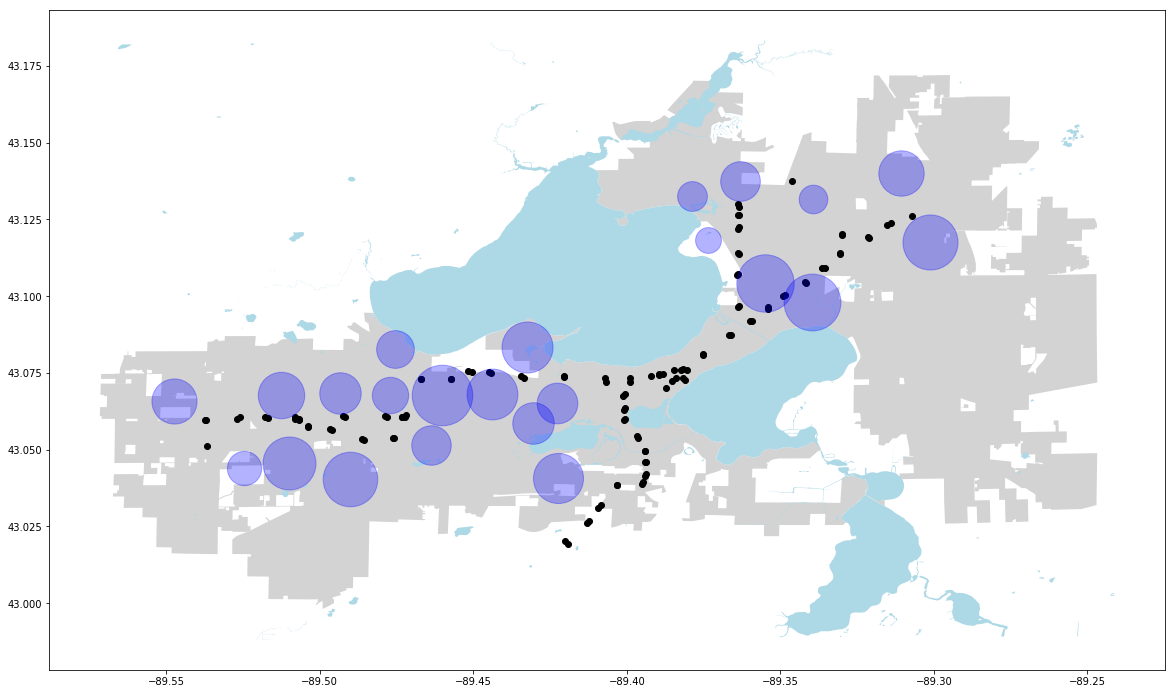

In [195]:

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
data.fillna(0, inplace=True)
dic = range(0, len(fourmile))
dic = list(dic)
i = 0
for index in adatatotal.index:
    locat = adatatotal[adatatotal.index==index]
    for coor in locat["lon"]:
        for coorr in locat["lat"]:
            homedic = []           
            homedic.append(Point(float(coor),float(coorr)))
            hcoords = pd.Series(homedic)
            hs = pd.DataFrame({"Coordinates": hcoords})
            hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
            total = locat["total"]
            pop=float(total)*5
            dic[i] = hs
            dic[i].plot(color="blue", ax=ax, markersize=pop*0.5, alpha=0.3)
            i += 1

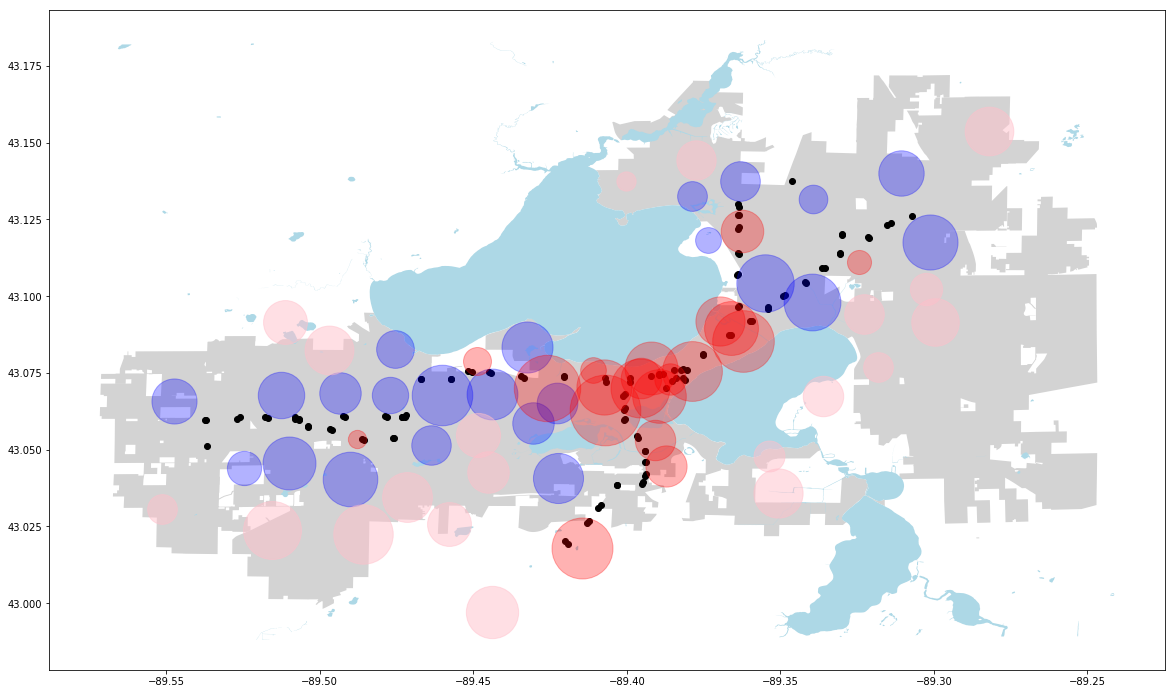

In [196]:
#annotate commute data from the the total sums with same coordinates, ssdatatotal, adatatotal, testtotal
#making the dots bigger according to travel size 
#reference_____https://pynative.com/python-generate-random-string/
#reference_____http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
#mport random
#import string

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
data.fillna(0, inplace=True)
dic = range(0, len(fourmile))
dic = list(dic)
i = 0
for index in adatatotal.index:
    locat = adatatotal[adatatotal.index==index]
    for coor in locat["lon"]:
        for coorr in locat["lat"]:
            homedic = []           
            homedic.append(Point(float(coor),float(coorr)))
            hcoords = pd.Series(homedic)
            hs = pd.DataFrame({"Coordinates": hcoords})
            hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
            total = locat["total"]
            pop=float(total)*5
            dic[i] = hs
            dic[i].plot(color="blue", ax=ax, markersize=pop*0.5, alpha=0.3)
            i += 1
for index in testtotal.index:
    locat = testtotal[testtotal.index==index]
    for coor in locat["lon"]:
        for coorr in locat["lat"]:
            homedic = []           
            homedic.append(Point(float(coor),float(coorr)))
            hcoords = pd.Series(homedic)
            hs = pd.DataFrame({"Coordinates": hcoords})
            hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
            total = locat["total"]
            pop=float(total)*5
            dic[i] = hs
            dic[i].plot(color="pink", ax=ax, markersize=pop*0.5, alpha=0.5)
            i += 1
for index in ssdatatotal.index:
    locat = ssdatatotal[ssdatatotal.index==index]
    for coor in locat["lon"]:
        for coorr in locat["lat"]:
            homedic = []           
            homedic.append(Point(float(coor),float(coorr)))
            hcoords = pd.Series(homedic)
            hs = pd.DataFrame({"Coordinates": hcoords})
            hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
            total = locat["total"]
            pop=float(total)*5
            dic[i] = hs
            dic[i].plot(color="red", ax=ax, markersize=pop*0.5, alpha=0.3)
            i += 1


In [197]:
#test, adata, ssdata
test.drop('DES_ID', axis=1, inplace=True)
test.drop('DES_ID_1', axis=1, inplace=True)
test.drop('DES_LENGTH', axis=1, inplace=True)
test.drop('OBJECTID_1', axis=1, inplace=True)
test.drop('OBJECTID', axis=1, inplace=True)
test.drop('ORG_DES_ID', axis=1, inplace=True)
test.drop('ORG_DES_ID_1', axis=1, inplace=True)
test.drop('ORG_ID', axis=1, inplace=True)
test.drop('ORG_ID_1', axis=1, inplace=True)
test.drop('RESIDENCE', axis=1, inplace=True)
test.drop('ShapeSTLength', axis=1, inplace=True)
test.drop('WORKPLACE', axis=1, inplace=True)
test.drop('coordinates', axis=1, inplace=True)
test.drop('coor', axis=1, inplace=True)
test.drop('coorr', axis=1, inplace=True)
test=test.sum()
adata.drop('DES_ID', axis=1, inplace=True)
adata.drop('DES_ID_1', axis=1, inplace=True)
adata.drop('DES_LENGTH', axis=1, inplace=True)
adata.drop('OBJECTID_1', axis=1, inplace=True)
adata.drop('OBJECTID', axis=1, inplace=True)
adata.drop('ORG_DES_ID', axis=1, inplace=True)
adata.drop('ORG_DES_ID_1', axis=1, inplace=True)
adata.drop('ORG_ID', axis=1, inplace=True)
adata.drop('ORG_ID_1', axis=1, inplace=True)
adata.drop('RESIDENCE', axis=1, inplace=True)
adata.drop('ShapeSTLength', axis=1, inplace=True)
adata.drop('WORKPLACE', axis=1, inplace=True)
adata.drop('coordinates', axis=1, inplace=True)
adata.drop('coor', axis=1, inplace=True)
adata.drop('coorr', axis=1, inplace=True)
adata=adata.sum()
adata
ssdata.drop('DES_ID', axis=1, inplace=True)
ssdata.drop('DES_ID_1', axis=1, inplace=True)
ssdata.drop('DES_LENGTH', axis=1, inplace=True)
ssdata.drop('OBJECTID_1', axis=1, inplace=True)
ssdata.drop('OBJECTID', axis=1, inplace=True)
ssdata.drop('ORG_DES_ID', axis=1, inplace=True)
ssdata.drop('ORG_DES_ID_1', axis=1, inplace=True)
ssdata.drop('ORG_ID', axis=1, inplace=True)
ssdata.drop('ORG_ID_1', axis=1, inplace=True)
ssdata.drop('RESIDENCE', axis=1, inplace=True)
ssdata.drop('ShapeSTLength', axis=1, inplace=True)
ssdata.drop('WORKPLACE', axis=1, inplace=True)
ssdata.drop('coordinates', axis=1, inplace=True)
ssdata.drop('coor', axis=1, inplace=True)
ssdata.drop('coorr', axis=1, inplace=True)
ssdata=ssdata.sum()
ssdata

Bicycle        2499.0
Bus            2872.0
Carpool2        852.0
Carpool3         94.0
Carpool4         34.0
Carpool5         40.0
Carpool7         15.0
DroveAlone     6469.0
Ferry            15.0
Motorcycle       58.0
Other            69.0
Rail              0.0
Subway            0.0
Taxi             40.0
Total         19279.0
Trolley           0.0
Walked         6229.0
WorkedHome        0.0
dtype: float64

In [202]:
#stacked data of all the 3 picked high density commute
final=pd.concat([ssdata, adata, test],axis=1, join_axes=[test.index])
final=pd.DataFrame(final)
final.columns = ['walking distance', 'more than 10 min' ,'more than 30 min']
final=final.transpose()

final.drop('Ferry', axis=1, inplace=True)
final.drop('Rail', axis=1, inplace=True)
final.drop('Subway', axis=1, inplace=True)
final.drop('Trolley', axis=1, inplace=True)
final.drop('WorkedHome', axis=1, inplace=True)
final

Bicycle     Bus  Carpool2  Carpool3  Carpool4  Carpool5  \
walking distance   2499.0  2872.0     852.0      94.0      34.0      40.0   
more than 10 min   1285.0  3714.0    1663.0     269.0      15.0      24.0   
more than 30 min    584.0   936.0    1726.0     247.0     128.0      15.0   

                  Carpool7  DroveAlone  Motorcycle  Other  Taxi    Total  \
walking distance      15.0      6469.0        58.0   69.0  40.0  19279.0   
more than 10 min      45.0     11453.0        44.0   10.0   4.0  19025.0   
more than 30 min       0.0     11331.0        55.0   48.0  15.0  15199.0   

                  Walked  
walking distance  6229.0  
more than 10 min   475.0  
more than 30 min    40.0

Text(0.5, 0, 'Number of commuters')

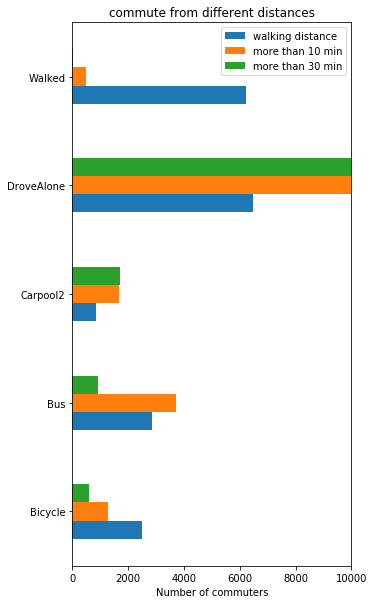

In [203]:
fig, ax = subplots()
final.drop('Taxi', axis=1, inplace=True)
final.drop('Other', axis=1, inplace=True)
final.drop('Motorcycle', axis=1, inplace=True)
final.drop('Carpool7', axis=1, inplace=True)
final.drop('Carpool5', axis=1, inplace=True)
final.drop('Carpool4', axis=1, inplace=True)
final.drop('Carpool3', axis=1, inplace=True)
final.drop('Total', axis=1, inplace=True)
finalplot=final.T.plot.barh(figsize=(5,10),title="commute from different distances",xlim=(0,10000), ax=ax) 
finalplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
finalplot.set_xlabel("Number of commuters")

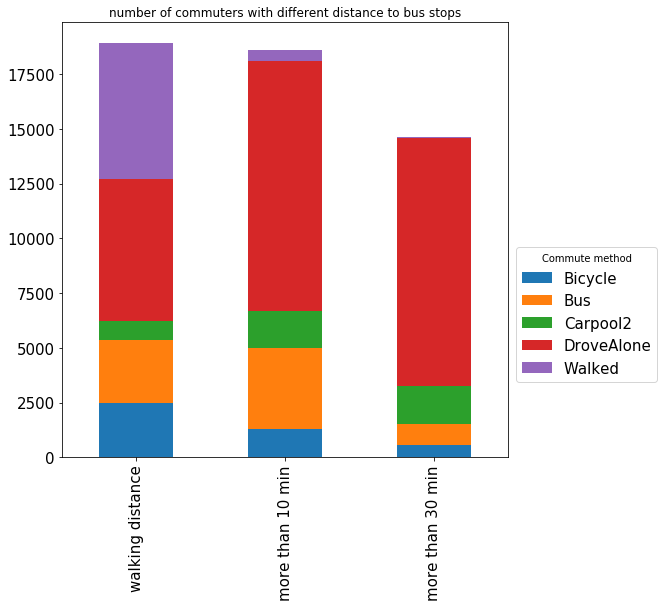

In [206]:
fig, ax = subplots()
finalstack=final.transpose().T.plot.bar(figsize=(8,8), stacked= True, title="number of commuters with different distance to bus stops", fontsize=15, ax=ax)
finalstack.legend(title='Commute method', bbox_to_anchor=(1, 0.5), fontsize = 15)